# Concevez une application au service de la santé publique

Objectifs: 
-  Traiter le jeu de données afin de repérer des variables pertinentes pour les traitements à venir. Automatiser ces traitements pour éviter de répéter ces opérations. Le programme doit fonctionner si la base de données est légèrement modifiée (ajout d’entrées, par exemple). 
- Tout au long de l’analyse, produire des visualisations afin de mieux comprendre les données. Effectuer une analyse univariée pour chaque variable intéressante, afin de synthétiser son comportement. L’appel à projets spécifie que l’analyse doit être simple à comprendre pour un public néophyte. Soyez donc attentif à la lisibilité : taille des textes, choix des couleurs, netteté suffisante, et variez les graphiques (boxplots, histogrammes, diagrammes circulaires, nuages de points…) pour illustrer au mieux votre propos.
-  Confirmer ou infirmer les hypothèses  à l’aide d’une analyse multivariée. Effectuer les tests statistiques appropriés pour vérifier la significativité des résultats.
- Élaborer une idée d’application. Identifier des arguments justifiant la faisabilité (ou non) de l’application à partir des données Open Food Facts.
- Rédiger un rapport d’exploration et pitcher votre idée durant la soutenance du projet.

# Idée d'application

Les recommandations du PNNS sont les suivantes:
- Au moins 5 fruits et légumes par jour
- Des féculents à chaque repas selon l’appétit
- 3 produits laitiers (lait, yaourt, fromage) par jour
- 1 à 2 portions de viande, œufs et produits de la pêche par jour
- Limiter les matières grasses ajoutées, le sucre et le sel

A partir d'un aliment scanné, proposer une sélection de yaourt et/ou fruit(s) pour se rapprocher, sur le repas, des recommandations de santé en termes des apports en macronutriments:

* nutriments
    - lipides 35-40% Apports en Energie Totaux
    - protides 10-20% AET
    - glucides 40-55% AET
    - fibres: 30g (environ 2-3% AET)

On va donc avoir besoin de renseignements concernant les apports nutritionnels et notamment l'énergie, les apports en protéines, lipides, glucides et fibres ainsi que les types d'aliments. Eventuellement, on pourra y ajouter le nutriscore et l'ecoscore pour pouvoir faire une sélection des produits les plus écologiques et sains (dans leur catégorie).

# Sommaire
### [I Exploration du jeu de données et sélection des variables](#I-Exploration-du-jeu-de-données-et-sélection-des-variables)
__[ I.1 Chargement des données et sélection des variables](#I.1-Chargement-des-données-et-sélection-des-variables)__\
__[I.2 Nettoyage du jeu de données: valeurs incohérentes et/ou extrêmes](#I.2-Nettoyage-du-jeu-de-données:-valeurs-incohérentes-et/ou-extrêmes)__\
[I.2.1 Conversion des valeurs en grammes en valeurs en kcal](#I.2.1-Conversion-des-valeurs-en-grammes-en-valeurs-en-kcal)\
[I.2.2 Nettoyage des valeurs aberrantes (1): conversion en kcal des valeurs données en kJ](#I.2.2-Nettoyage-des-valeurs-aberrantes-(1):-conversion-en-kcal-des-valeurs-données-en-kJ)\
[I.2.3 Nettoyage des valeurs aberrantes (2): sélection des individus non aberrants par la différence entre énergie calculée et énergie renseignée](#I.2.3-Nettoyage-des-valeurs-aberrantes-(2):-sélection-des-individus-non-aberrants-par-la-différence-entre-énergie-calculée-et-énergie-renseignée)\
__[I.3 Traitement des valeurs manquantes](#I.3-Traitement-des-valeurs-manquantes)__\
[](#)
[I.3.2 Nettoyage des valeurs aberrantes (bis)](#I.3.2-Nettoyage-des-valeurs-aberrantes-(bis))\
__[I.5 Reformulation des valeurs nutritionnelles en fonction des serving_quantity](#I.5-Reformulation-des-valeurs-nutritionnelles-en-fonction-des-serving_quantity)__

### [II Analyse exploratoire](#II-Analyse-exploratoire)
__[II.1 Répartitions typiques de l'énergie et des macronutriments](#II.1-Répartitions-typiques-de-l'énergie-et-des-macronutriments)__\
[II.1.1 Répartition générale](#II.1.1-Répartition-générale)\
[II.1.2 Les catégories One-dish meals, Fruits et Milk and yogurt](#II.1.2-Les-catégories-One-dish-meals,-Fruits-et-Milk-and-yogurt)\
[II.1.3 Représentation des proportions de chaque macronutriment dans le bilan global](#II.1.3-Représentation-des-proportions-de-chaque-macronutriment-dans-le-bilan-global)\
[II.1.4 Association d'un macronutriment dominant avec un groupe de produits](#II.1.4-Association-d'un-macronutriment-dominant-avec-un-groupe-de-produits)\
__[II.2 Scores](#II.2-Scores)__\
[II.2.1 Score reflétant l'équilibre entre les macronutriments: EquiScore](#II.2.1-Score-reflétant-l'équilibre-entre-les-macronutriments:-EquiScore)\
[II.2.2 Distribution des valeurs du nutriscore](#II.2.2-Distribution-des-valeurs-du-nutriscore)\
[II.2.3 Analyse croisée des scores](#II.2.3-Analyse-croisée-des-scores)\
[II.2.4 EquiScore, Nutriscore et groupes d'aliments](#II.2.4-EquiScore,-Nutriscore-et-groupes-d'aliments)\
__[II.3 Analyse des corrélations](#II.3-Analyse-des-corrélations)__\
[II.3.1 Matrice des corrélations](#II.3.1-Matrice-des-corrélations)

# I Exploration du jeu de données et sélection des variables

## I.1 Chargement des données et sélection des variables

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as mticker
#from mticker import AutoMinorLocator
import statsmodels.api as sm
from statsmodels.formula.api import ols
import missingno as msno

# Module pour le nettoyage du notebook.
import functions_p3 as fp3

In [317]:
# dataset à analyser
dataset = "./en.openfoodfacts.org.products.csv"

# variables retenues pour l'analyse
selected_cols = ['product_name',
                 'categories_tags',
                 'countries_tags',
                 'serving_quantity',
                 'pnns_groups_2',
                 'energy-kcal_100g',
                 'fat_100g',
                 'nutrition-score-fr_100g',
                 'nutriscore_grade',
                 'fiber_100g',
                 'proteins_100g',
                 'carbohydrates_100g']

# restriction aux pays pour lesquels countries_tags="en:france"
restr="en:france"

# Chargement du dataset, sélection des variable (colonnes) et restriction aux countries_tags="en:france"
df1 = fp3.load_select(dataset, selected_cols, restr)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (0,8,13,19,20,21,22,23,27,28,29,31,38,47,52,55,64,134) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Aperçu global du jeu de données, avec les variables sélectionnées.
1. Aperçu des premières lignes et colonnes

In [318]:
df1.head()

,product_name,categories_tags,serving_quantity,pnns_groups_2,energy-kcal_100g,fat_100g,nutrition-score-fr_100g,nutriscore_grade,fiber_100g,proteins_100g,carbohydrates_100g
0,jeunes pousses,NaN,NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Vitória crackers,NaN,NaN,unknown,375.0,7.0,NaN,NaN,NaN,7.8,70.1
2,Cacao,NaN,NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,moutarde au moût de raisin,"en:groceries,en:condiments,en:sauces,en:mustards",NaN,Dressings and sauces,NaN,8.2,18.0,d,0.0,5.1,29.0
6,Sfiudwx,fr:xsf,NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [319]:
# Restriction aux "One dish meal", "Fruits" et "Yoghourts"
selected_groups = ['One-dish meals','Fruits', 'Milk and yogurt', 'fruits']
df1 = df1.loc[df1.pnns_groups_2.isin(selected_groups)]
    
###### fusion des pnns_groups "Fruits" et "fruits"
df1.loc[:, "pnns_groups_2"] = df1["pnns_groups_2"].apply(lambda x: "Fruits" if x=='fruits' else x)

##### Ecriture du dataframe dans un fichier csv
df1.to_csv('./df1.csv', index_label=False)

2. Matrice de remplissage

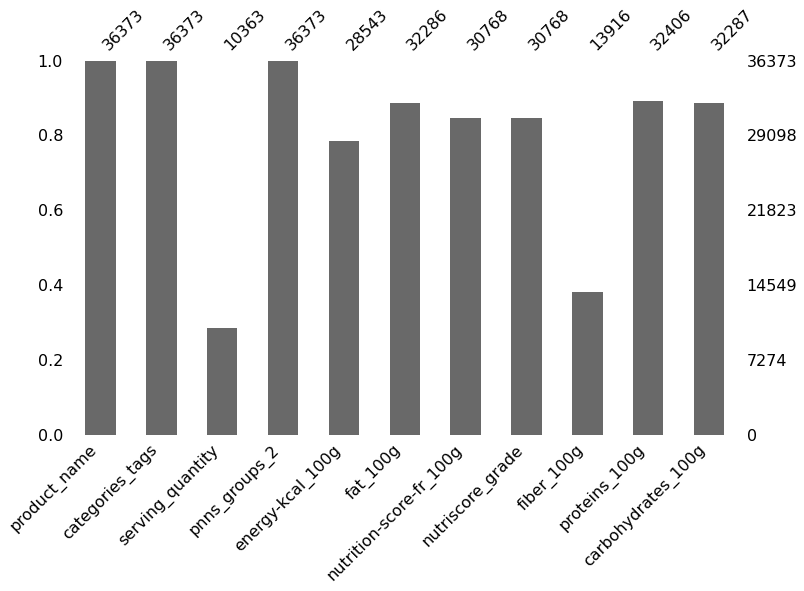

In [421]:
msno.bar(df1, figsize=(12, 8))
plt.gcf().subplots_adjust(bottom=0.25, top=0.9)
plt.savefig("./graphes/alldata_fillmat.png", dpi=300)
plt.show()

## I.2 Nettoyage du jeu de données: valeurs incohérentes et/ou extrêmes

In [410]:
df1 = pd.read_csv("./df1.csv")
df1.head()

,product_name,categories_tags,serving_quantity,pnns_groups_2,energy-kcal_100g,fat_100g,nutrition-score-fr_100g,nutriscore_grade,fiber_100g,proteins_100g,carbohydrates_100g
16,Salade de carottes râpées,"en:meals,en:prepared-vegetables,en:grated-carr...",NaN,One-dish meals,32.0,0.3,1.0,b,NaN,0.9,5.3
35,Compote de poire,"en:plant-based-foods-and-beverages,en:plant-ba...",NaN,Fruits,157.0,0.0,-2.0,a,3.6,0.6,36.0
39,Salade de macedoine de légumes,"en:meals,en:prepared-vegetables,en:starters,en...",NaN,One-dish meals,143.0,12.7,1.0,b,NaN,1.9,3.9
74,CORNED BEEF,"en:canned-foods,en:meats,en:meals,en:meat-base...",NaN,One-dish meals,235.0,15.0,17.0,d,NaN,24.0,1.0
94,Salade Grecque,"en:meals,en:salads,en:prepared-salads",NaN,One-dish meals,64.0,2.3,1.0,b,NaN,3.7,1.8


Il y a clairement des valeurs atypiques et/ou aberrantes dans ce jeu de données...

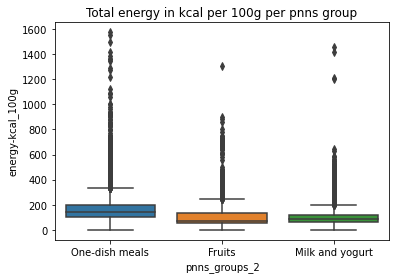

Proportion de valeurs atypiques et/ou aberrantes, hors de l'intervalle [Q1 - 1,5(Q3-Q1), Q3 + 1,5(Q3-Q1)]:
Proportion pour  One-dish meals : 0.13
Proportion pour  Fruits : 0.15
Proportion pour  Milk and yogurt : 0.13


In [228]:
## graphe
sns.boxplot(x=df1["pnns_groups_2"],
            y=df1["energy-kcal_100g"],
           )
#plt.xlabel("energy-kcal_100g")
#plt.ylabel("total_energy_from_nutriments")
plt.title("Total energy in kcal per 100g per pnns group")
plt.show()

print("Proportion de valeurs atypiques et/ou aberrantes, hors de l'intervalle [Q1 - 1,5(Q3-Q1), Q3 + 1,5(Q3-Q1)]:")
for g in df1["pnns_groups_2"].unique():
    data = df1.loc[df1.pnns_groups_2==g, "energy-kcal_100g"]
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    max_val = q1 + 1.5*(q3-q1)
    outliers = data[data > max_val]
    proportion_outliers = outliers.shape[0]/data.shape[0]
    print("Proportion pour ", g,": {:.2f}".format(proportion_outliers))

### I.2.1 Conversion des valeurs en grammes en valeurs en kcal

Comme notre application consiste en la sélection de produits permettant d'atteindre les ANC, et que ces dernières sont généralement données en % des apports énergétiques, on commence par créer de nouvelles colonnes contenant les valeurs en kcal associées aux macronutriments, et renseignées en g.

In [342]:
# Colonnes sur lesquelles opérer les conversions
start_cols = ["fat_100g", "carbohydrates_100g", "proteins_100g", "fiber_100g"]

# Colonnes à créer avec le coefficient de conversion g --> kcal associé
new_cols = [("fat_kcal", 9), ("carbohydrates_kcal", 4), ("proteins_kcal", 4), ("fiber_kcal", 1.9)]

# Conversions et créations des colonnes
for (nc, sc) in zip(new_cols, start_cols):
    df1 = fp3.weight_to_energy(df1, sc, nc[0], nc[1])

    
# Calcul de la somme des valeurs obtenues pour chaque ligne et création d'une nouvelle colonne
# "total_energy_from_nutriments"
df1.loc[:, "total_energy_from_nutrients"] = df1[["fat_kcal","carbohydrates_kcal","proteins_kcal", "fiber_kcal"]].apply(lambda x: np.sum(x), axis=1)

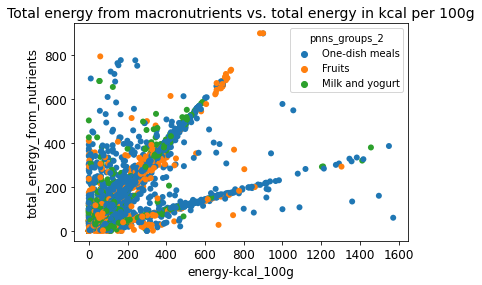

In [5]:
## graphe

# fontsize
fs = 12

fig, ax = plt.subplots()

sns.scatterplot(x="energy-kcal_100g", 
                y="total_energy_from_nutrients",
                data=df1,
                linewidth=0,
                hue="pnns_groups_2",
                ax=ax
               )
plt.xlabel("energy-kcal_100g", fontsize=fs)
plt.ylabel("total_energy_from_nutrients", fontsize=fs)
ax.tick_params(axis="y", labelsize=fs)
ax.tick_params(axis="x", labelsize=fs)
plt.title("Total energy from macronutrients vs. total energy in kcal per 100g", fontsize=14)
plt.savefig("./graphes/kj_kcal_1.png")
plt.show()

Etrange relation entre les deux variables... On s'attend à une relation linéaire de coefficient 1, mais deux relations semblent se dégager, la deuxième semblant à première vue correspondre à un coefficient d'environ 0,25:\
total_energy_from_nutriments = 0,25 $\times$ energy-kcal_100g.\
Peut-on corriger ces valeurs incohérentes?

### I.2.2 Nettoyage des valeurs aberrantes (1): conversion en kcal des valeurs données en kJ

Certaines valeurs renseignées dans la colonne "energy-kcal_100g" apparaissent être en fait des valeurs données en kJ. On récupère ces valeurs en sélectionnant les valeurs dans un intervalle ad hoc autour de 4,18 $\times$ total_energy_from_nutriments, et en leur appliquant le facteur de conversion $0,239=\frac{1}{4,18}$.

In [343]:
## Calcul du ratio de l'énergie calculée à partir des valeurs de macronutriments sur l'énergie renseignée
col2="energy-kcal_100g"
col1="total_energy_from_nutrients"
ratio = fp3.create_distrib(df1, col1=col1, col2=col2, reverse_cols=False, method="ratio", mask="notna")

Affichons la distribution "ratio"

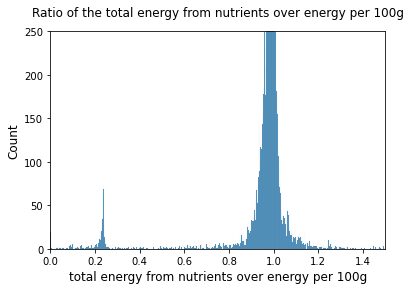

In [150]:
sns.histplot(ratio[ratio<2])
plt.xlim([0, 1.5])
plt.ylim([0, 250])
plt.title("Ratio of the total energy from nutrients over energy per 100g", pad=15)
plt.xlabel("total energy from nutrients over energy per 100g", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

In [344]:
# on ne garde dans la Series ratio que les valeurs comprises entre 0.1 et 0.4. Les valeurs intéressantes 
# se trouvent vers 0.25 et ainsi on peut calculer une moyenne et un écart-type raisonnables sur cette 
# distribution
ratio = ratio[(ratio>0.1) & (ratio<0.4)]

# Moyenne et écart-type de la "distribution" ratio
mean = ratio.mean()
sigma = ratio.std()

# cut-off associés
cut_off_high = mean + sigma
cut_off_low = mean - sigma

df1 = fp3.joule_to_kcal(df1, "energy-kcal_100g", "total_energy_from_nutrients", cut_off_high, cut_off_low)

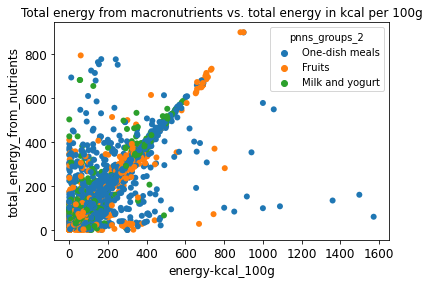

In [193]:
## graphe

# fontsize
fs = 12

fig, ax = plt.subplots()

sns.scatterplot(x="energy-kcal_100g", 
                y="total_energy_from_nutrients",
                data=df1,
                linewidth=0,
                hue="pnns_groups_2",
                ax=ax
               )
plt.xlabel("energy-kcal_100g", fontsize=fs)
plt.ylabel("total_energy_from_nutrients", fontsize=fs)
ax.tick_params(axis="y", labelsize=fs)
ax.tick_params(axis="x", labelsize=fs)
plt.title("Total energy from macronutrients vs. total energy in kcal per 100g", fontsize=fs)
plt.savefig("./graphes/kj_kcal_2.png")
plt.show()

Le nettoyage a bien été réalisé comme on le souhaitait.

### I.2.3 Nettoyage des valeurs aberrantes (2): sélection des individus non aberrants par la différence entre énergie calculée et énergie renseignée

Certaines valeurs sont simplement aberrantes: l'énergie globale renseignée ne correspond pas du tout à l'énergie qu'on peut calculer à partir des macronutriments. En repérant ces valeurs, on peut ainsi retirer un bon nombre de valeurs incohérentes.

In [345]:
# Remplacement des valeurs nulles par des NaN pour faciliter le traitement
for col in ["total_energy_from_nutrients", "energy-kcal_100g"]:
    df1 = fp3.replace_with_nan(df1, col)

# On arrondit les valeurs de total_energy_from_nutriments.
rounded_val = df1["total_energy_from_nutrients"].apply(lambda x: np.round(x))
df1.loc[:, "total_energy_from_nutrients"] = rounded_val

# Création de la colonne complete_vars: True si toutes les colonnes target_cols sont renseignées, False sinon.
target_cols = ["total_energy_from_nutrients",
          "energy-kcal_100g",
          "fat_kcal",
          "carbohydrates_kcal",
          "proteins_kcal",
          "fiber_kcal"]
df1 = fp3.make_mask(df1, target_cols, "isna")

# On crée la distribution représentant la différence total_energy_from_nutriments - energy-kcal_100g
# Cette distribution n'est calculée que sur les lignes pour lesquelles complete_vars est True, c'est-à-dire
# les lignes pour lesquelles toutes les données sont renseignées.
diff = fp3.create_distrib(df1, mask="complete_vars")

# Ajout d'une colonne contenant la valeur de la différence entre l'énergie calculée  et l'énergie renseignée.
df1.loc[:, "diff"] = diff

Affichage de la distribution et de ses principales propriétés.

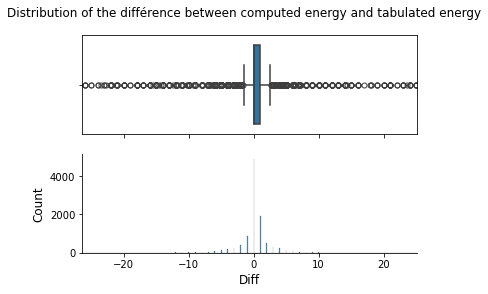

In [195]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
fig.suptitle("Distribution of the différence between computed energy and tabulated energy")
flierprops = dict(marker="o", markerfacecolor="none")
sns.boxplot(x="diff",
            data=df1,
            flierprops=flierprops,
            ax=ax1
           )
ax1.set_xlabel("")
ax1.set_xlim([-10, 10])
sns.histplot(x="diff",
             data=df1,
             ax=ax2
            )
ax2.set_xlim([diff.mean()-diff.std(), diff.mean()+diff.std()])
ax2.set_xlabel("Diff", fontsize=12)
ax2.set_ylabel("Count", fontsize=12)
sns.despine(ax=ax2)
plt.show()

In [21]:
print("\"Diff\" statistics (difference between computed energy and tabulated energy)")
print(df1["diff"].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))

"Diff" statistics (difference between computed energy and tabulated energy)
count    11048.000000
mean        -0.628224
std         25.763468
min       -736.000000
5%          -5.000000
25%          0.000000
50%          0.000000
75%          1.000000
95%          4.000000
max        901.000000
Name: diff, dtype: float64


In [346]:
# Création d'un dataframe ne contenant que les bonnes valeurs
df1_no = df1.loc[df1.complete_vars==True].copy()
df1_no = df1_no.loc[np.abs(df1_no["diff"]-diff.mean())<2*diff.quantile(0.95)] # On ne conserve que les valeurs 
                                                                              # situées à moins de 10 unités de
                                                                              # la moyenne.
# Mise à jour du dataframe
#Y = df1.loc[df1.complete_vars==True].copy()
#drop_index = Y.loc[np.abs(Y["diff"]-diff.mean())>2*diff.quantile(0.95)].index # On ne conserve que les valeurs 
                                                                              # situées à moins de 10 unités 
                                                                              # (~ 2*diff.quantile(0.95)) de
                                                                              # la moyenne.
#df1.drop(index=drop_index, inplace=True)

# on retire les colonnes complete_vars et diff qui ne sont plus utiles
#drop_cols = ["complete_vars", "diff"]
#df1.drop(columns=drop_cols, inplace=True)
#df1_no.drop(columns=drop_cols, inplace=True)

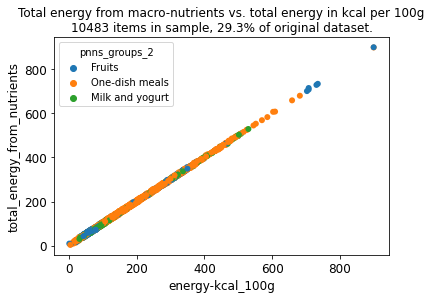

In [198]:
## graphe

# fontsize
fs = 12

fig, ax = plt.subplots()
sns.scatterplot(x="energy-kcal_100g", 
                y="total_energy_from_nutrients",
                data=df1_no,
                linewidth=0,
                hue="pnns_groups_2",
                ax=ax
               )
plt.xlabel("energy-kcal_100g", fontsize=fs)
plt.ylabel("total_energy_from_nutrients", fontsize=fs)
ax.tick_params(axis="y", labelsize=fs)
ax.tick_params(axis="x", labelsize=fs)
plt.title('''Total energy from macro-nutrients vs. total energy in kcal per 100g
{} items in sample, {:.1f}% of original dataset.'''.format(df1_no.shape[0],
                                                                          100*df1_no.shape[0]/df1.shape[0]))
plt.savefig("./graphes/no_1.png")
plt.show()

<AxesSubplot:>

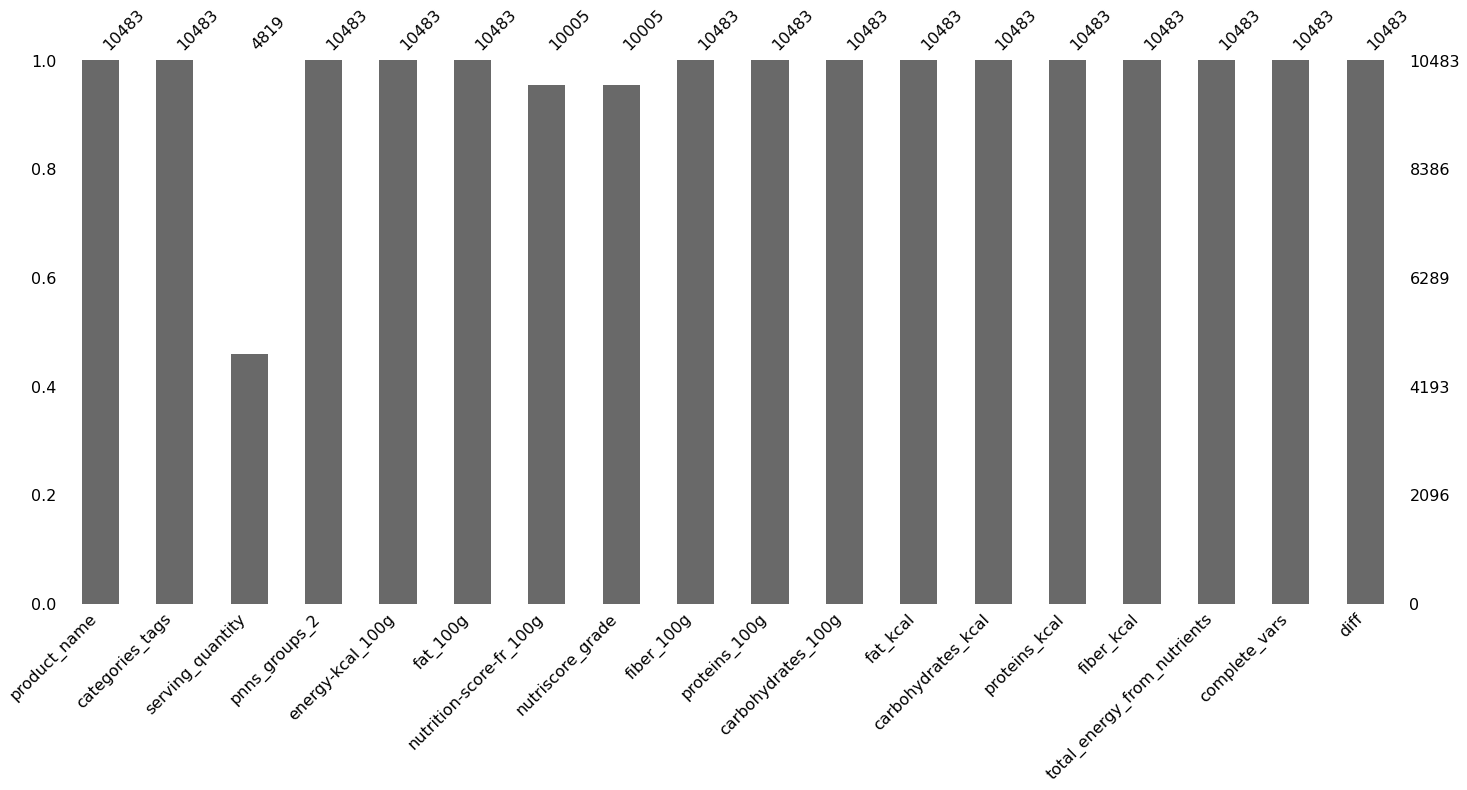

In [347]:
msno.bar(df1_no)

Imputation des serving size manquants à l'aide du mode pour chaque groupe PNNS

In [349]:
groups_mode = df1_no.groupby("pnns_groups_2")["serving_quantity"].aggregate(lambda x: x.mode()).to_dict()
df1_no.loc[:, "serving_quantity"] = df1_no[["pnns_groups_2", "serving_quantity"]].apply(lambda x: x.fillna(groups_mode[x["pnns_groups_2"]]), axis=1)

<AxesSubplot:>

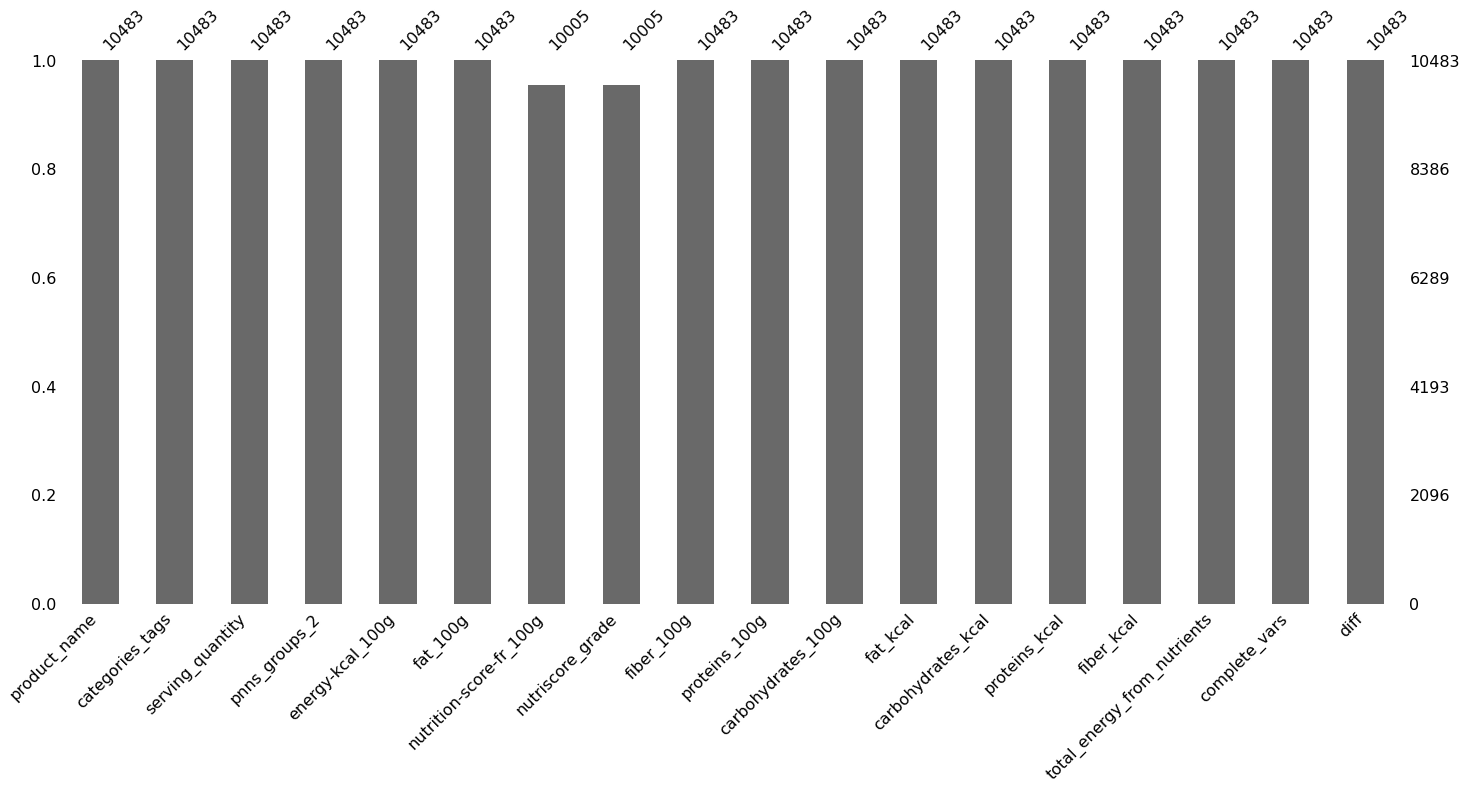

In [350]:
msno.bar(df1_no)

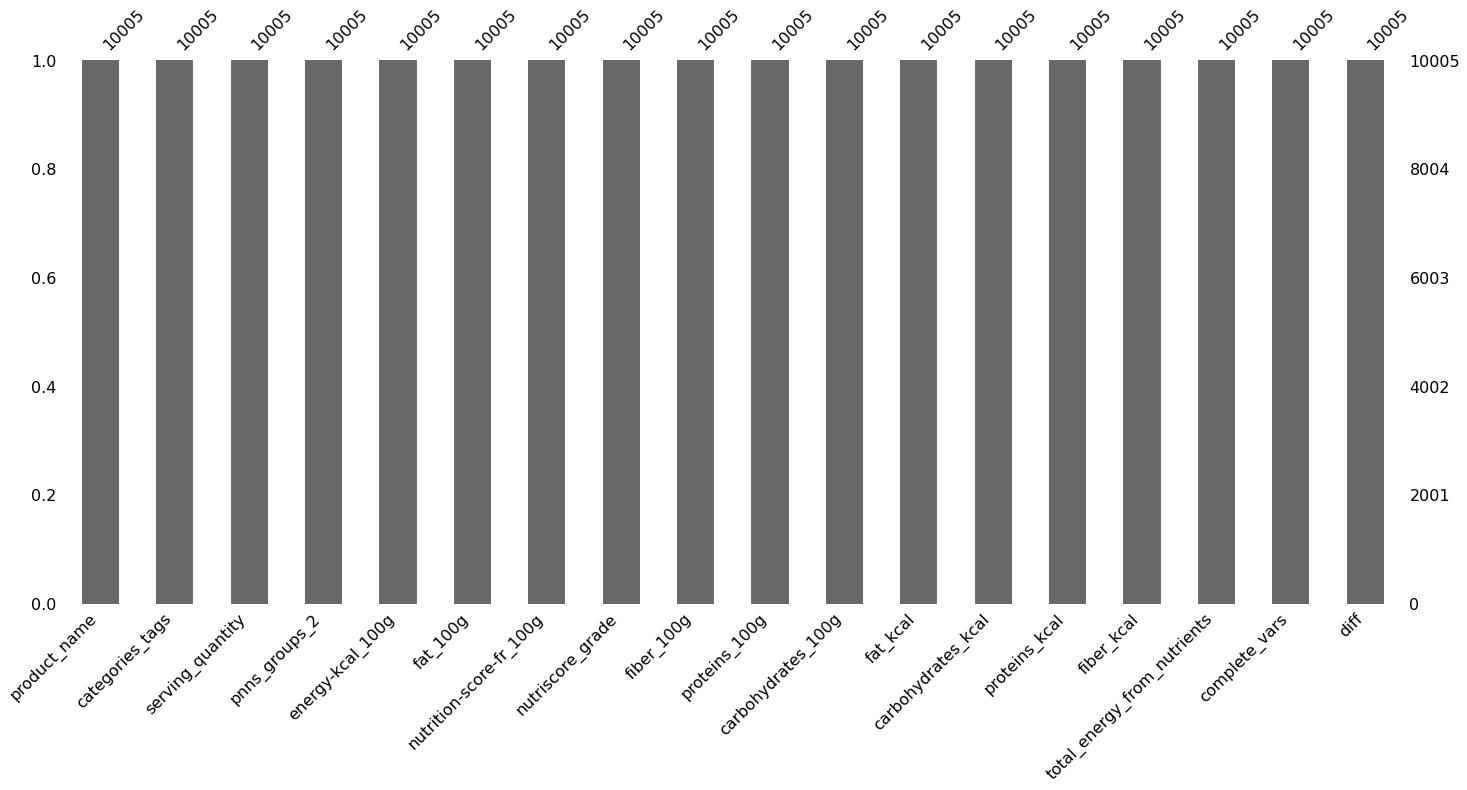

In [351]:
df1_no.dropna(subset=["nutrition-score-fr_100g"], inplace=True)
msno.bar(df1_no)
plt.show()

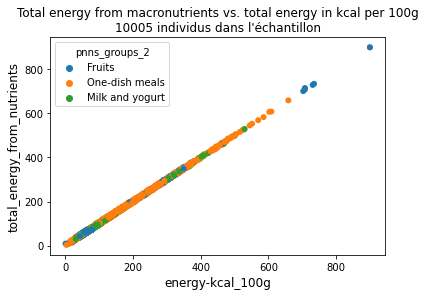

In [352]:
## graphe
sns.scatterplot(x="energy-kcal_100g", 
                y="total_energy_from_nutrients",
                data=df1_no,
                linewidth=0,
                hue="pnns_groups_2"
               )
plt.xlabel("energy-kcal_100g", fontsize=12)
plt.ylabel("total_energy_from_nutrients", fontsize=12)
plt.title('''Total energy from macronutrients vs. total energy in kcal per 100g
{} individus dans l'échantillon'''.format(df1_no.shape[0]))
plt.show()

## I.5 Reformulation des valeurs nutritionnelles en fonction des serving_quantity

In [353]:
X = df1_no.copy()

X.loc[:, "fat_kcal"] = X[["serving_quantity", "fat_kcal"]].apply(lambda x: x[1]*x[0]/100, axis=1)
X.loc[:, "carbohydrates_kcal"] = X[["serving_quantity", "carbohydrates_kcal"]].apply(lambda x: x[1]*x[0]/100, axis=1)
X.loc[:, "proteins_kcal"] = X[["serving_quantity", "proteins_kcal"]].apply(lambda x: x[1]*x[0]/100, axis=1)
X.loc[:, "fiber_kcal"] = X[["serving_quantity", "fiber_kcal"]].apply(lambda x: x[1]*x[0]/100, axis=1)
X.loc[:, "total_energy_from_nutrients"] = X[["serving_quantity", "total_energy_from_nutrients"]].apply(lambda x: x[1]*x[0]/100, axis=1)

df1_no = X

In [355]:
# reindexation du dataframe
df1_no.index = pd.Index(range(0, df1_no.shape[0]))
df1_no.to_csv("./df1_nomissing.csv", index_label=False)

<AxesSubplot:xlabel='energy-kcal_100g', ylabel='total_energy_from_nutrients'>

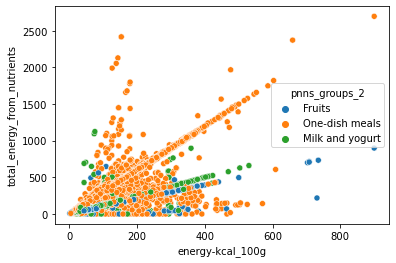

In [354]:
sns.scatterplot(x="energy-kcal_100g", y="total_energy_from_nutrients", data=df1_no, hue="pnns_groups_2")

# II Analyse exploratoire

In [441]:
df1 = pd.read_csv("./df1_nomissing.csv")

## II.1 Répartitions typiques de l'énergie et des macronutriments

### II.1.1 Répartition générale

On commence par explorer les distributions associées aux différents macronutriments et à l'énergie sur le jeu de données global.

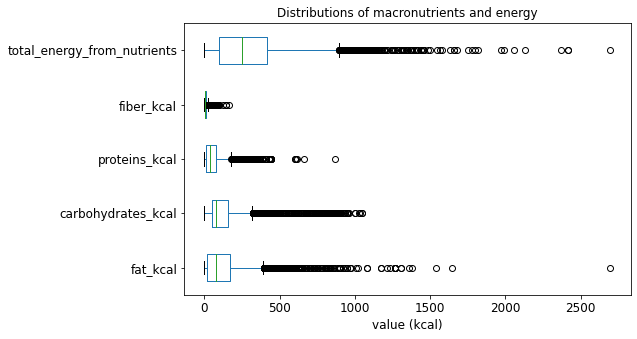

In [423]:
flierprops = {"marker":'o'}
ax=df1[["fat_kcal",
   "carbohydrates_kcal",
   "proteins_kcal",
   "fiber_kcal",
   "total_energy_from_nutrients"]].plot(kind="box",
                                        vert=False, 
                                        showfliers=True,
                                        flierprops=flierprops,
                                        fontsize=12,
                                        xlabel="value (kcal)",
                                        figsize=(8, 5),
                                        title="Distributions of macronutrients and energy")
ax.set_xlabel("value (kcal)", fontsize=12)
plt.show()

On exclu le point de valeurs les plus élevées: il semble être un outlier.

In [424]:
df1.iloc[df1.fat_kcal.idxmax()]

product_name                                               Piémontaise au jambon
categories_tags                en:meals,en:meat-based-products,en:salads,en:m...
serving_quantity                                                             300
pnns_groups_2                                                     One-dish meals
energy-kcal_100g                                                             900
fat_100g                                                                    99.9
nutrition-score-fr_100g                                                       20
nutriscore_grade                                                               e
fiber_100g                                                                     0
proteins_100g                                                                  0
carbohydrates_100g                                                             0
fat_kcal                                                                  2697.3
carbohydrates_kcal          

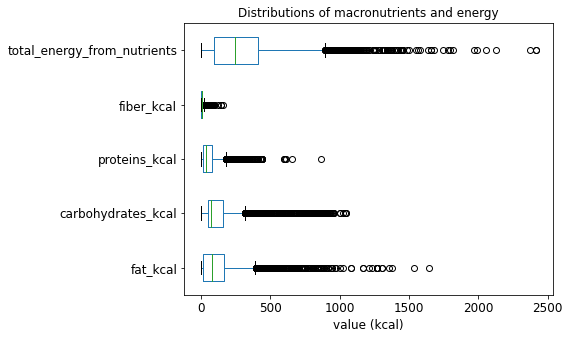

----------------------------------------
Moyennes en kcal des différentes valeurs nutritionnelles sur le dataset global:
fat_kcal                       116.746627
carbohydrates_kcal             115.490368
proteins_kcal                   52.038335
fiber_kcal                       7.564873
total_energy_from_nutrients    291.840768
dtype: float64
----------------------------------------
Médianes en kcal des différentes valeurs nutritionnelles sur le dataset global:
fat_kcal                        78.300000
carbohydrates_kcal              75.600002
proteins_kcal                   34.800000
fiber_kcal                       4.750000
total_energy_from_nutrients    246.000000
dtype: float64
Minima et maxima:
fat_kcal                       0.0
carbohydrates_kcal             0.0
proteins_kcal                  0.0
fiber_kcal                     0.0
total_energy_from_nutrients    0.0
dtype: float64
fat_kcal                       1539.000
carbohydrates_kcal             1044.000
proteins_kcal       

In [442]:
outlier = df1.fat_kcal.idxmax()
df1.drop(index=outlier, inplace=True)

ax=df1[["fat_kcal",
   "carbohydrates_kcal",
   "proteins_kcal",
   "fiber_kcal",
   "total_energy_from_nutrients"]].plot(kind="box",
                                        vert=False, 
                                        showfliers=True,
                                        flierprops=flierprops,
                                        fontsize=12,
                                        xlabel="value (kcal)",
                                        figsize=(8, 5),
                                        title="Distributions of macronutrients and energy")
ax.set_xlabel("value (kcal)", fontsize=12)
plt.gcf().subplots_adjust(left=0.35, right=0.99)
plt.savefig("./graphes/general_distrib.png")
plt.show()

print("-"*40)
print("Moyennes en kcal des différentes valeurs nutritionnelles sur le dataset global:")
print(df1[["fat_kcal",
   "carbohydrates_kcal",
   "proteins_kcal",
   "fiber_kcal",
   "total_energy_from_nutrients"]].mean())
print("-"*40)
print("Médianes en kcal des différentes valeurs nutritionnelles sur le dataset global:")
print(df1[["fat_kcal",
   "carbohydrates_kcal",
   "proteins_kcal",
   "fiber_kcal",
   "total_energy_from_nutrients"]].median())
print("Minima et maxima:")
print(df1[["fat_kcal",
   "carbohydrates_kcal",
   "proteins_kcal",
   "fiber_kcal",
   "total_energy_from_nutrients"]].min())
print(df1.drop(index=df1.fat_kcal.idxmax())[["fat_kcal",
   "carbohydrates_kcal",
   "proteins_kcal",
   "fiber_kcal",
   "total_energy_from_nutrients"]].max())

Maintenant les valeurs typiques, sans les outliers.

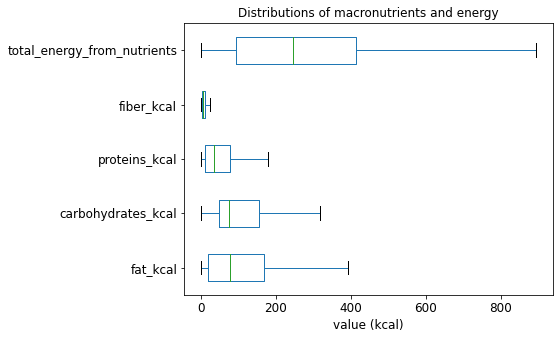

In [443]:
ax=df1[["fat_kcal",
   "carbohydrates_kcal",
   "proteins_kcal",
   "fiber_kcal",
   "total_energy_from_nutrients"]].plot(kind="box",
                                        vert=False, 
                                        showfliers=False,
                                        flierprops=flierprops,
                                        fontsize=12,
                                        xlabel="value (kcal)",
                                        figsize=(8, 5),
                                        title="Distributions of macronutrients and energy")
ax.set_xlabel("value (kcal)", fontsize=12)
plt.gcf().subplots_adjust(left=0.35, right=0.99)
plt.savefig("./graphes/general_distrib.png", dpi=300)
plt.show()

### II.1.2 Les catégories One-dish meals, Fruits et Milk and yogurt

Combien de représentants de chaque catégorie?

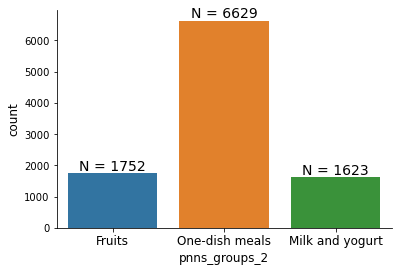

In [444]:
fig, ax = plt.subplots()
sns.countplot(x="pnns_groups_2",
              data=df1,
              ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
#ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.set_xlabel(ax.get_xlabel(), fontsize=12)
ax.set_ylabel(ax.get_ylabel(), fontsize=12)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate("N = {:.0f}".format(y), (x.mean(), y), 
            ha='center', va='bottom', fontsize=14) # set the alignment of the text
sns.despine(ax=ax)
plt.savefig("./graphes/categories.png", dpi=300)
plt.show()

Les One-dish meals sont largement surreprésentés par rapport aux deux autres catégories. Il faudra savoir en tenir compte. En attendant, regardons comment leur composition diffère.

### II.1.3 Représentation des proportions de chaque macronutriment dans le bilan global

On commence par créer un dataframe regroupant les valeurs moyennes des macronutriments pour chaque groupe d'aliment. Comme les ANC ne reposent que sur les répartitions en lipides, glucides et protéines (les fibres étant comptées à part), on ne fera reposer l'analyse qui suit que sur les répartitions de ces macronutriments.

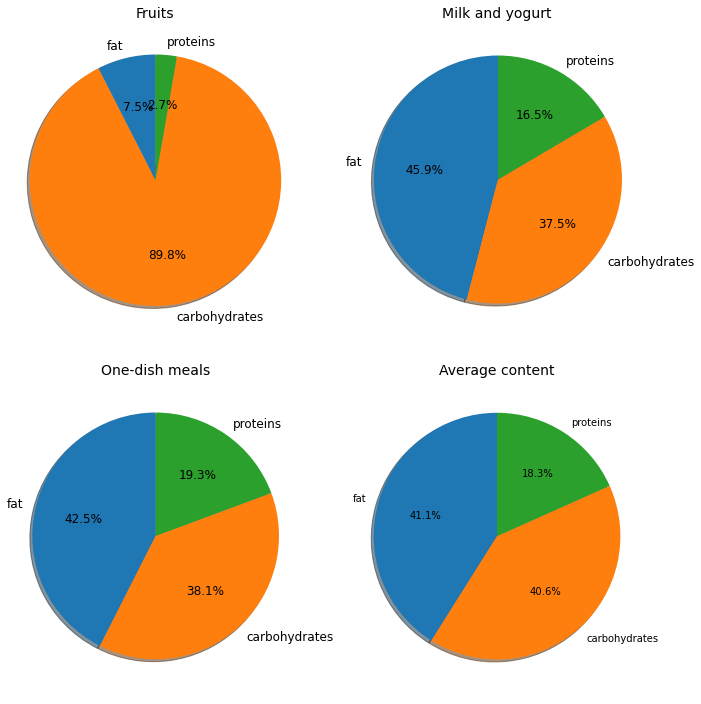

In [368]:
# On groupe les valeurs par catégorie d'aliment.
gr = df1.groupby("pnns_groups_2")[["fat_kcal", "carbohydrates_kcal", "proteins_kcal"]].mean()

# A titre de comparaison, on récupère aussi les valeurs moyennes sur l'ensemble du dataset.
gen = df1[["fat_kcal", "carbohydrates_kcal", "proteins_kcal"]].mean()

# On représente ces valeurs moyennes sous forme de proportion au bilan global pour chaque groupe d'aliment.
# Représentation sous forme de pie chart
labels = ["fat", "carbohydrates","proteins"]

# placement des titres
pad=0

# Taille de la police
fs = 14

txtprs = {"fontsize":12}

fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax1.pie(gr.loc["Fruits"], textprops=txtprs, labels=labels, autopct='%1.1f%%',
shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Fruits", pad=pad, fontsize=fs)

ax2.pie(gr.loc["Milk and yogurt"], textprops=txtprs, labels=labels, autopct='%1.1f%%',
shadow=True, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title("Milk and yogurt", pad=pad, fontsize=fs)

ax3.pie(gr.loc["One-dish meals"], textprops=txtprs, labels=labels, autopct='%1.1f%%',
shadow=True, startangle=90)
ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax3.set_title("One-dish meals", pad=pad, fontsize=fs)

ax4.pie(gen, labels=labels, autopct='%1.1f%%',
shadow=True, startangle=90)
ax4.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax4.set_title("Average content", pad=pad, fontsize=fs)


plt.tight_layout(pad=1.5)
plt.savefig("./graphes/pies.png")
plt.show()

Average content très proche de One-dish meals. Pas si étonnant si on regarde le nombre de one-dish meals par rapport aux autres groupes. A titre de comparaison, voici la répartition obtenue si on respecte les ANC:

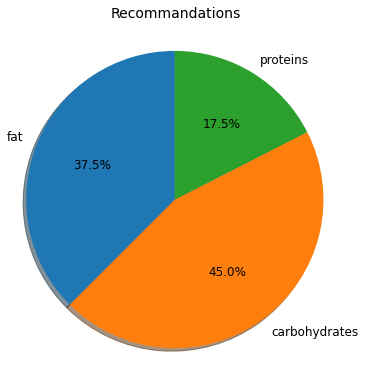

In [256]:
# Valeurs idéales
p_fat = 37.5 # fourchette de 35% à 40%
p_carbs = 45 # fourchette de 40% à 55%
p_prot = 17.5 # fourchette de 15% à 20%

anc = [p_fat, p_carbs, p_prot]
labels = ["fat", "carbohydrates","proteins"]
txtprs = {"fontsize":12}

fig, ax = plt.subplots(figsize=(6, 6))

ax.pie(anc, labels=labels, autopct='%1.1f%%',
       shadow=True, startangle=90, textprops=txtprs)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title("Recommandations", pad=20, fontsize=14)
plt.savefig("./graphes/anc.png")
plt.show()

Le contenu moyen est très proche des valeurs recommandées, mais on peut déjà envisager l'utilité de ccombiner des plats de différentes natures pour parvenir à un meilleur équilibre.

### II.1.4 Association d'un macronutriment dominant avec un groupe de produits

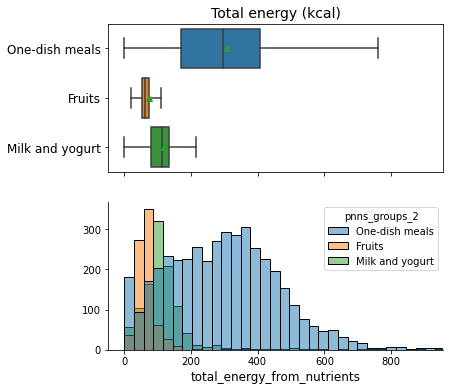

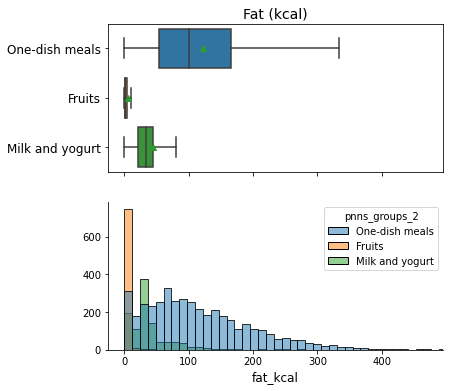

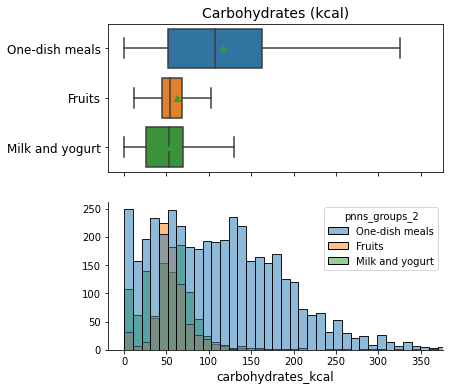

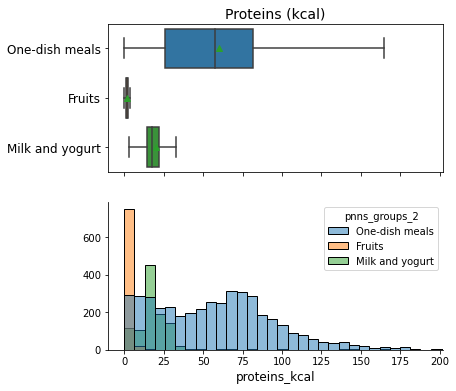

In [258]:
nutricols = ["total_energy_from_nutrients", "fat_kcal", "carbohydrates_kcal", "proteins_kcal"]
titles = {"total_energy_from_nutrients": "Total energy (kcal)",
          "fat_kcal": "Fat (kcal)",
          "carbohydrates_kcal": "Carbohydrates (kcal)",
          "proteins_kcal": "Proteins (kcal)"
         }

for c in nutricols:
    q = df1.groupby("pnns_groups_2")[c].quantile(0.99).max()
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 6), sharex=True)
    sns.boxplot(x=c,
                y="pnns_groups_2",
                data=df1,
                showfliers=False,
                showmeans=True,
                #palette="viridis",
                ax=ax1)
    ax1.set_xlabel("")
    ax1.set_ylabel("")
    ax1.tick_params(axis='y', labelsize=12)
    #ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=12)
    ax1.set_xlim([-q/20, q])
    ax1.set_title(titles[c], fontsize=14)
    
    sns.histplot(x=c,
                 data=df1,
                 hue="pnns_groups_2",
                 ax=ax2
            )
    ax2.set_xlim([-q/20, q])
    ax2.set_xlabel(ax2.get_xlabel(), fontsize=12)
    ax1.tick_params(axis='x', labelsize=12)
    #ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=12)
    ax2.set_ylabel("")
    #ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=10)
    sns.despine(ax=ax2)
    plt.tight_layout
    plt.show()

Chaque groupe d'aliment est associé à une présence plus forte, en moyenne, d'un ou plusieurs macronutriments. On peut ainsi effectuer les rapprochements suivants, sur la base des quelques analyses réalisées ci-dessus:
- les One-dish meals sont en général les produits les plus énergétiques, et constituent la source majeure de lipides et de protéines,
- Les Fruits sont en général la source majeure de fibres et de glucides,
- Les Milk and yogurt consituent une source intermédiare de lipides et de protéines, mais sont pauvres en glucides et en fibres.

Les recommandations de l'application pourront reposer sur ces constatations pour proposer, en association avec un one-dish meal d'un score donné, le meilleur "type" de produit en fonction des apports à réduire ou à augmenter dans la balance globale.

## II.2 Scores

### II.2.1 Distance reflétant le (dés)équilibre entre les macronutriments: EquiScore

Pour pouvoir réaliser notre idée d'application, il est nécessaire d'avoir un indicateur qui renseigne sur l'écart d'un produit aux valeurs idéales, en terme de fraction du contenu global. On choisit ainsi d'utiliser la distance euclidienne entre la composition d'un produit donné et la composition idéale.

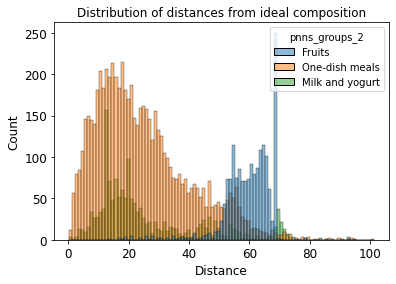

Some statistics about the distribution of distance from ideal composition:

All data:
Minimum: 0.33
Maximum: 101.18
Mean: 31.33
Median: 25.54
Standard deviation: 20.01
----------------------------------------
Fruits:
Minimum: 14.16
Maximum: 92.50
Mean: 59.87
Median: 60.86
Standard deviation: 7.84
----------------------------------------
One-dish meals:
Minimum: 0.33
Maximum: 101.18
Mean: 24.77
Median: 21.38
Standard deviation: 15.51
----------------------------------------
Milk and yogurt:
Minimum: 0.85
Maximum: 94.65
Mean: 27.20
Median: 20.01
Standard deviation: 18.57


In [451]:
X = df1.copy()
# On ne garde que les lignes pour lesquelles aucune des variables ne vaut 0
zeros = X[["fat_kcal", "carbohydrates_kcal", "proteins_kcal"]].sum(axis=1)==0
drop_index = zeros[zeros].index

X.drop(index=drop_index, inplace=True)

# On crée les nouvelles colonnes "fat_ratio", "carbohydrates_ratio" et "proteins_ratio" qui renseigneront sur 
# les ratio de macronutriments dans les contenus globaux.
X.loc[:, "fat_ratio"] = X.apply(lambda x: 100*x["fat_kcal"]/(x["fat_kcal"]+x["carbohydrates_kcal"]+x["proteins_kcal"]), axis=1)
X.loc[:, "carbohydrates_ratio"] = X.apply(lambda x: 100*x["carbohydrates_kcal"]/(x["fat_kcal"]+x["carbohydrates_kcal"]+x["proteins_kcal"]), axis=1)
X.loc[:, "proteins_ratio"] = X.apply(lambda x: 100*x["proteins_kcal"]/(x["fat_kcal"]+x["carbohydrates_kcal"]+x["proteins_kcal"]), axis=1)

sc = fp3.score(X["fat_ratio"], X["carbohydrates_ratio"], X["proteins_ratio"], method="sq")

# Nouvelle colonne "score" dans le dataframe
X.loc[:, "score"] = sc
X.head()

# mise à jour du dataframe
df1 = X

# fontsize
fs=12

fig, ax = plt.subplots()
# Affichage de la distribution de l'equiscore
sns.histplot(x="score",
            data=X,
             hue="pnns_groups_2",
             bins=101,
             ax=ax
           )
plt.title("Distribution of distances from ideal composition", fontsize=fs)
plt.xlabel("Distance", fontsize=fs)
plt.ylabel("Count", fontsize=fs)
ax.tick_params(axis='y', labelsize=fs)
ax.tick_params(axis='x', labelsize=fs)
plt.savefig("./graphes/distances.png")
plt.show()

print("Some statistics about the distribution of distance from ideal composition:\n")
print("All data:")
print("Minimum: {:.2f}".format(X["score"].min()))
print("Maximum: {:.2f}".format(X["score"].max()))
print("Mean: {:.2f}".format(X["score"].mean()))
print("Median: {:.2f}".format(X["score"].median()))
print("Standard deviation: {:.2f}".format(X["score"].std()))
for i in X.pnns_groups_2.unique():
    print("-"*40)
    print(i+":")
    print("Minimum: {:.2f}".format(X.loc[X.pnns_groups_2==i, ["score"]].min()[0]))
    print("Maximum: {:.2f}".format(X.loc[X.pnns_groups_2==i, ["score"]].max()[0]))
    print("Mean: {:.2f}".format(X.loc[X.pnns_groups_2==i, ["score"]].mean()[0]))
    print("Median: {:.2f}".format(X.loc[X.pnns_groups_2==i, ["score"]].median()[0]))
    print("Standard deviation: {:.2f}".format(X.loc[X.pnns_groups_2==i, ["score"]].std()[0]))




Les distribution de distance pour les One-dish meals et les Milk and yogurt sont assez similaires. Elles diffèrent en revanche franchement de la distribution pour les fruits, dont les scores sont regroupés vers les valeurs les plus élevées. La distance est liée aux "excès" ou de façon équivalente aux "carences" d'une composition vis-à-vis de la composition idéale. On va donc continuer d'explorer nos données en se concentrant sur les excès en chacun des macronutriments.

In [446]:
X = df1.copy()

# On crée trois nouvelles colonnes: "fat_excess", "carbohydrates_excess", "proteins_excess"
nutrient_cols = ["fat_excess", "carbohydrates_excess", "proteins_excess"]
X.loc[:, "fat_excess"] = X["fat_ratio"] - p_fat
X.loc[:, "carbohydrates_excess"] = X["carbohydrates_ratio"] - p_carbs
X.loc[:, "proteins_excess"] = X["proteins_ratio"] - p_prot

# On crée trois nouvelles colonnes: "fat_excess", "carbohydrates_excess", "proteins_excess"
nutrient_cols = ["fat_excess", "carbohydrates_excess", "proteins_excess"]


# On peuple les colonnes "max_excess" et "min_excess" par le nom du macronutriment associé à l'excès le plus 
# élevé en valeur algébrique, c'est-à-dire qu'un excès négatif représente une carence.
X.loc[:, "max_excess"] = X[nutrient_cols].apply(lambda x: x.idxmax(), axis=1)
X.loc[:, "min_excess"] = X[nutrient_cols].apply(lambda x: x.idxmin(), axis=1)
X.loc[:, "max_excess_value"] = X[nutrient_cols].apply(lambda x: x.max(), axis=1)
X.loc[:, "min_excess_value"] = X[nutrient_cols].apply(lambda x: x.min(), axis=1)

# mise à jour du dataframe
df1 = X

df1.head()

,product_name,categories_tags,serving_quantity,pnns_groups_2,energy-kcal_100g,fat_100g,nutrition-score-fr_100g,nutriscore_grade,fiber_100g,proteins_100g,...,carbohydrates_ratio,proteins_ratio,score,fat_excess,carbohydrates_excess,proteins_excess,max_excess,min_excess,max_excess_value,min_excess_value
0,Compote de poire,"en:plant-based-foods-and-beverages,en:plant-ba...",100.0,Fruits,157.0,0.0,-2.0,a,3.6,0.6,...,98.360656,1.639344,67.120563,-37.500000,53.360656,-15.860656,carbohydrates_excess,fat_excess,53.360656,-37.500000
1,Galette de Pommes de Terre,"en:plant-based-foods-and-beverages,en:plant-ba...",300.0,One-dish meals,137.0,3.1,3.0,c,2.2,2.2,...,72.343632,6.631500,33.722819,-16.475132,27.343632,-10.868500,carbohydrates_excess,fat_excess,27.343632,-16.475132
2,Quenelles de brochet sauce Nantua,"en:meals,en:meals-with-fish,fr:quenelles,en:fi...",300.0,One-dish meals,140.0,11.0,16.0,d,0.5,4.6,...,14.804064,13.352685,45.917901,34.343251,-30.195936,-4.147315,fat_excess,carbohydrates_excess,34.343251,-30.195936
3,Salade fusili,"en:meals,en:pasta-dishes,en:salads,en:prepared...",215.0,One-dish meals,125.0,3.5,-2.0,a,1.3,6.7,...,52.016461,22.057613,14.281518,-11.574074,7.016461,4.557613,carbohydrates_excess,fat_excess,7.016461,-11.574074
4,Coleslaw,"en:meals,en:starters,en:coleslaw",150.0,One-dish meals,155.0,12.5,1.0,b,2.5,1.1,...,21.910488,2.939212,46.504702,37.650301,-23.089512,-14.560788,fat_excess,carbohydrates_excess,37.650301,-23.089512


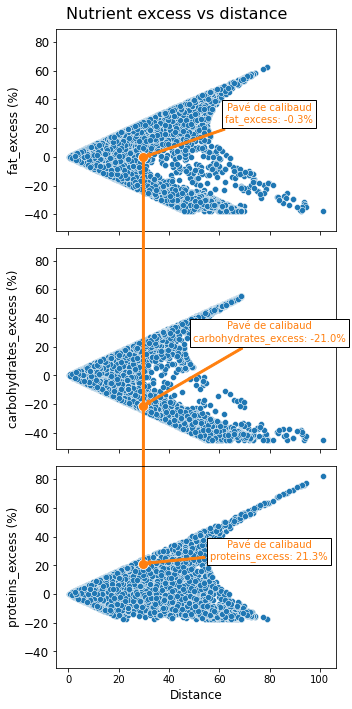

In [371]:
X = df1.copy()

from matplotlib.patches import ConnectionPatch

# placement du titre
pad = 12

# taille de la police
fs = 12

# choix d'un nombre aléatoire compris entre 0 et len(X)
np.random.seed(3)
r = np.random.choice(X[(X.score>20)&(X.score<40)].shape[0], 1)
product = X.iloc[r]

fig, axs = plt.subplots(nrows=len(nutrient_cols), figsize=(5, 10), sharex=True, sharey=True)
fig.suptitle("Nutrient excess vs distance", fontsize=16)
for i, nc in enumerate(nutrient_cols):
    ax=axs[i]
    sns.scatterplot(y=nc, 
                    x="score", 
                    data=X,
                    ax=ax)
    sns.scatterplot(y=nc, x="score", data=product, color="C1", s=100, ax=ax)
    ax.annotate(product["product_name"].iloc[0]+"\n"+nc+": {:.1f}%".format(product[nc].iloc[0]),
                (product["score"], product[nc]), 
                (product["score"]+50, 30),
                ha="center",
                va="center",
                color="C1",
               arrowprops = {"arrowstyle":"simple", "color":"C1"},
               bbox=dict(boxstyle="square,pad=0.3", fc="white", lw=1))
    ax.set_xlabel("Distance", fontsize=fs)
    ax.set_ylabel("{} (%)".format(nc), fontsize=fs)
    ax.tick_params(axis='y', labelsize=fs)
    #ax.set_yticklabels(ax1.get_yticklabels(), fontsize=12)
    #ax.set_xlim([-q/20, q])
    #ax.set_title(product["product_name"].iloc[0], fontsize=12, loc="right")

xyA = (product["score"],product[nutrient_cols[-1]])
xyB = (product["score"],product[nutrient_cols[0]])
coordsA = "data"
coordsB = "data"
con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA="data", coordsB="data",
                      axesA=axs[-1], axesB=axs[0], color="C1",
                     )
con.set_linewidth(3)
axs[-1].add_artist(con)
plt.tight_layout()
plt.savefig("./graphes/nutrient_distance.png")
plt.show()

On range les produits en 4 classes distinctes, correspondant aux 25ème, 50ème et 75ème percentiles, de manière à avoir 4 classes équilibrées. On nomme ces classes 1, 2, 3 et 4. Ainsi, on définit un score allant de 1 à 4, reflétant l'écart entre la composition d'un produit et la composition idéale, et qu'on nomme "equiscore".

In [474]:
X["score"].describe(percentiles=[0.25, 0.50, 0.75])

count    9800.000000
mean       31.327549
std        20.007322
min         0.334046
25%        14.769803
50%        25.539105
75%        49.497462
max       101.180532
Name: score, dtype: float64

In [483]:
# discrétisation du score
tranches = [0, 
            15, 
            25, 
            50
           ]
groups = np.digitize(X["score"], tranches)
X.loc[:, "equiscore"] = groups

df1 = X
df1.head()

,product_name,categories_tags,serving_quantity,pnns_groups_2,energy-kcal_100g,fat_100g,nutrition-score-fr_100g,nutriscore_grade,fiber_100g,proteins_100g,...,proteins_ratio,score,fat_excess,carbohydrates_excess,proteins_excess,max_excess,min_excess,max_excess_value,min_excess_value,equiscore
0,Compote de poire,"en:plant-based-foods-and-beverages,en:plant-ba...",100.0,Fruits,157.0,0.0,-2.0,a,3.6,0.6,...,1.639344,67.120563,-37.500000,53.360656,-15.860656,carbohydrates_excess,fat_excess,53.360656,-37.500000,4
1,Galette de Pommes de Terre,"en:plant-based-foods-and-beverages,en:plant-ba...",300.0,One-dish meals,137.0,3.1,3.0,c,2.2,2.2,...,6.631500,33.722819,-16.475132,27.343632,-10.868500,carbohydrates_excess,fat_excess,27.343632,-16.475132,3
2,Quenelles de brochet sauce Nantua,"en:meals,en:meals-with-fish,fr:quenelles,en:fi...",300.0,One-dish meals,140.0,11.0,16.0,d,0.5,4.6,...,13.352685,45.917901,34.343251,-30.195936,-4.147315,fat_excess,carbohydrates_excess,34.343251,-30.195936,3
3,Salade fusili,"en:meals,en:pasta-dishes,en:salads,en:prepared...",215.0,One-dish meals,125.0,3.5,-2.0,a,1.3,6.7,...,22.057613,14.281518,-11.574074,7.016461,4.557613,carbohydrates_excess,fat_excess,7.016461,-11.574074,1
4,Coleslaw,"en:meals,en:starters,en:coleslaw",150.0,One-dish meals,155.0,12.5,1.0,b,2.5,1.1,...,2.939212,46.504702,37.650301,-23.089512,-14.560788,fat_excess,carbohydrates_excess,37.650301,-23.089512,3


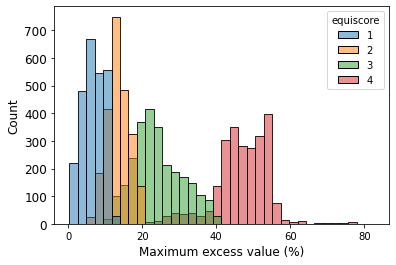

In [484]:
X = df1.copy()

fs = 12

fig, ax = plt.subplots()
sns.histplot(x="max_excess_value", 
             data=X.sort_values(by="equiscore"),  
             hue="equiscore",
             palette="tab10",
            ax=ax)
ax.set_xlabel("Maximum excess value (%)", fontsize=fs)
ax.set_ylabel("Count", fontsize=fs)
ax.tick_params(axis='y', labelsize=fs)
plt.savefig("./graphes/maxexcess_vs_equiscore.png")
plt.show()

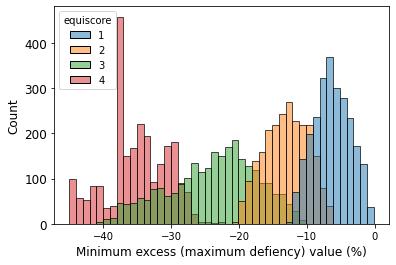

In [485]:
fs = 12

fig, ax = plt.subplots()

sns.histplot(x="min_excess_value", 
             data=X.sort_values(by="equiscore"), 
             bins=int(np.abs(X.min_excess_value).max()), 
             hue="equiscore",
             palette="tab10",
            ax=ax)
ax.set_xlabel("Minimum excess (maximum defiency) value (%)", fontsize=fs)
ax.set_ylabel("Count", fontsize=fs)
ax.tick_params(axis='y', labelsize=fs)
plt.savefig("./graphes/minexcess_vs_equiscore.png")
plt.show()

**Quelle est la relation entre l'equiscore et le type de macronutriments dont l'excès (la carence) est maximal(e) ? L'equiscore et le type de nutriment en excès sont-ils corrélés?**

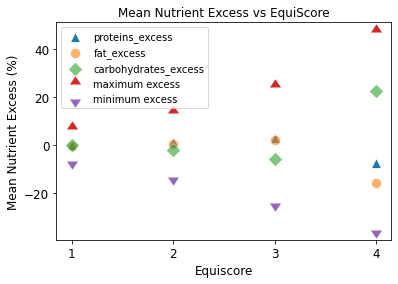

In [492]:
score_groups = X.groupby("equiscore").mean()
fig, ax = plt.subplots()

sns.scatterplot(x="equiscore", y="proteins_excess", data=score_groups, ax=ax, label="proteins_excess", marker="^", s=100)
sns.scatterplot(x="equiscore", y="fat_excess", data=score_groups, ax=ax, label="fat_excess", marker="o", s=100, alpha=0.60)
sns.scatterplot(x="equiscore", y="carbohydrates_excess", data=score_groups, ax=ax, label="carbohydrates_excess", marker="D", s=100, alpha=0.60)
sns.scatterplot(x="equiscore", y="max_excess_value", data = score_groups, ax=ax, label="maximum excess", marker=10, s=100)
sns.scatterplot(x="equiscore", y="min_excess_value", data = score_groups, ax=ax, label="minimum excess", marker=11, s=100)
ax.set_xlabel("Equiscore", fontsize=12)
ax.set_ylabel("Mean Nutrient Excess (%)", fontsize=12)
ax.set_title("Mean Nutrient Excess vs EquiScore", fontsize=12)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_xticks([1, 2, 3, 4])

plt.legend()

plt.savefig('./graphes/excess_equiscore.png', dpi=300)
plt.show()

Tableau de contingence:


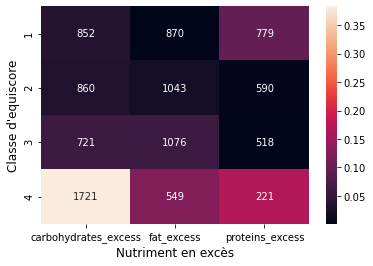

In [376]:
# Création du tableau de contingence
x = "score_group"
y = "max_excess"

cont = X[[x,y]].pivot_table(index=x,columns=y,aggfunc=len,margins=True,margins_name="Total")
tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = cont.loc["Total", "Total"]
indep = tx.dot(ty) / n

c = cont.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1], fmt=".0f")
plt.ylabel("Classe d'equiscore", fontsize=12)
plt.xlabel("Nutriment en excès", fontsize=12)
print("Tableau de contingence:")
plt.show()

Etant donné la valeur très élevée de la distance du khi-deux (> 3040), on en déduit l'existence d'une corrélation entre le type de nutriment le plus en excès et la classe d'equiscore.

En particulier:

- Dans la classe d'equiscore 4 les excès en glucides sont les excès principaux dans 67% des cas
- 40% des produits dont l'excès principal provient des glucides sont des produits de classe 4
- Dans cette même classe d'equiscore (4), les produits dont l'excès principal est un excès en protéines sont particulièrement sous-représentés: ils ne représentent que 9% des produits, tandis qu'ils représentent 22% des produits toutes catégories confondues.
- Enfin, les produits dont l'excès en protéines est le principal excès sont surreprésentés dans le groupe d'equiscore 1: ils représentent en effet 32% de l'ensemble des produits de classe 1.

La classe 1, associée aux produits les plus équilibrés par construction, est composée pour 1/3 de produits principalement "surchargés" en lipides, 1/3 en protéines, et 1/3 en glucides.

Tableau de contingence:


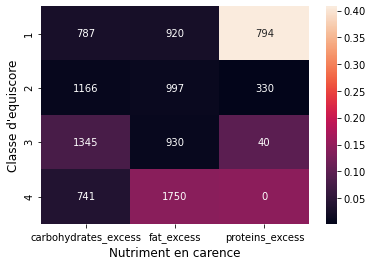

In [377]:
# Création du tableau de contingence
x = "score_group"
y = "min_excess"

cont = X[[x,y]].pivot_table(index=x,columns=y,aggfunc=len,margins=True,margins_name="Total")
tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = cont.loc["Total", "Total"]
indep = tx.dot(ty) / n

c = cont.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1], fmt=".0f")
plt.ylabel("Classe d'equiscore", fontsize=12)
plt.xlabel("Nutriment en carence", fontsize=12)
print("Tableau de contingence:")
plt.show()

Les produits de forte carence en protéines sont surreprésentés dans la classe d'equiscore a, les produits de fortes carences en glucides et lipides le sont dans les classe c et d, respectivement, où les produits carencés en protéines sont singulièrement sous-représentés.

### II.2.2 Distribution des valeurs du nutriscore

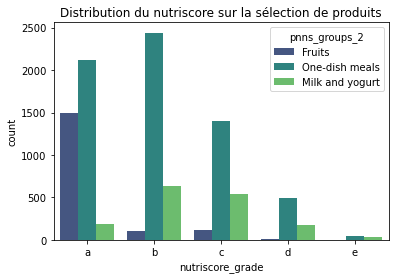

In [477]:
sns.countplot(x="nutriscore_grade",
            data=X.sort_values(by="nutriscore_grade"),
             palette="viridis",
             hue="pnns_groups_2")
plt.title("Distribution du nutriscore sur la sélection de produits")
plt.show()

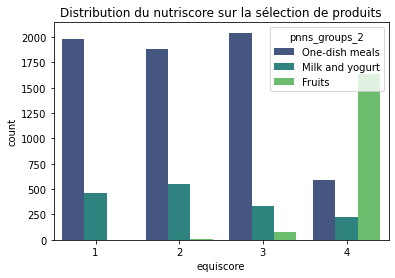

In [478]:
sns.countplot(x="equiscore",
            data=X.sort_values(by="equiscore"),
             palette="viridis",
             hue="pnns_groups_2")
plt.title("Distribution de l'equiscore sur la sélection de produits")
plt.show()

### II.2.3 Analyse croisée des scores

Il s'agit ici de regarder comment ces deux scores sont corrélés entre eux ou non. L'idée de l'application repose sur l'hypothèse que le nutriscore seul ne suffit pas pour sélectionner des produits dont la répartition des divers macronutriments se rapproche des ANC.

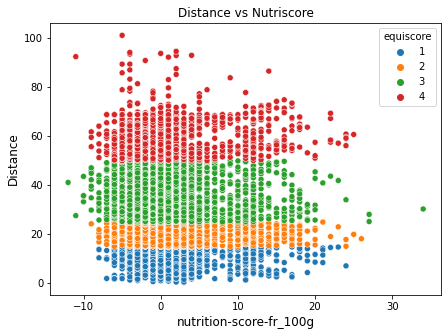

In [493]:
plt.figure(figsize=(7, 5))
sns.scatterplot(x="nutrition-score-fr_100g",
                y="score",
                data=X.sort_values(by="equiscore"),
                hue="equiscore",
                palette="tab10"
               )
plt.title("Distance vs Nutriscore")
plt.xlabel("nutrition-score-fr_100g", fontsize=12)
plt.ylabel("Distance", fontsize=12)
plt.savefig("./graphes/equiscore_nutriscore.png", dpi=300)
plt.show()

**Test d'indépendance distance (equiscore) vs. nutriscore par ANOVA**

Commençons par afficher les distribution des distances associées à chaque nutriscore sous forme de boxplots

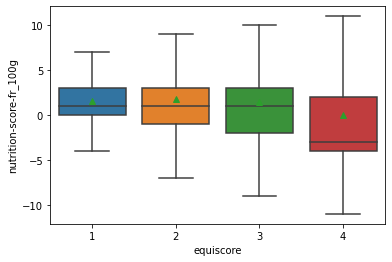

In [494]:
sns.boxplot(x="equiscore", 
            y="nutrition-score-fr_100g",
            data=X.sort_values(by="equiscore"),
            showmeans=True, 
            showfliers=False
           )

plt.show()

Difficile de comprendre exactement ce qu'il se passe ici. Affichons la distribution des nutrition score sour forme d'histogramme.

<AxesSubplot:xlabel='nutrition-score-fr_100g', ylabel='Count'>

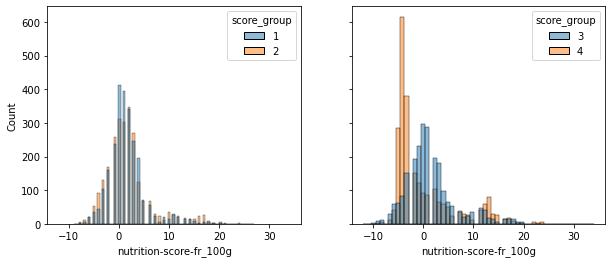

In [381]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharex=True, sharey=True)

sns.histplot(x="nutrition-score-fr_100g", data=X[X.score_group.isin([1, 2])], hue="score_group", palette="tab10", ax=ax1)
sns.histplot(x="nutrition-score-fr_100g", data=X[X.score_group.isin([3, 4])], hue="score_group", palette="tab10", ax=ax2)

Hypothèse: Les variables nutriscore et equiscore sont indépendantes pour les groupes d'equiscore 1, 2 et 3. En revanche, différence significative pour la classe d'equiscore 4.

In [479]:
y = df1.copy()
y.rename(columns={"nutrition-score-fr_100g":"nutriscore_score"}, inplace=True)
mod = ols('nutriscore_score ~ equiscore', data=y[y.equiscore.isin([1, 2, 3])].dropna(subset=["nutriscore_score", "equiscore"], how="any")).fit()           
aov_table = sm.stats.anova_lm(mod, typ=2)
esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
print("Résultats de l'ANOVA pour les variables equiscore et nutrition-score-fr_100g:")
print("F: {:.2f}, p: {:.3f}".format(aov_table.iloc[0]["F"], aov_table.iloc[0]["PR(>F)"]))
print("Eta-squared: {:.4f}".format(esq_sm))

Résultats de l'ANOVA pour les variables equiscore et nutrition-score-fr_100g:
F: 0.74, p: 0.391
Eta-squared: 0.0001


L'ANOVA sur les classes d'equiscore 1 à 3 confirme notre hypothèse. ANOVAs sur 4 vs. les autres classes.

In [481]:
y_4 = y[y.equiscore==4].copy()
y_4.loc[:, "id"] = np.full((y_4.shape[0], 1), 4)
y_o = y[y.equiscore!=4].copy()
y_o.loc[:, "id"] = np.full((y_o.shape[0], 1), 0)

In [482]:
yy = pd.concat([y_4, y_o])
mod = ols('nutriscore_score ~ id', data=yy.dropna(subset=["nutriscore_score", "id"], how="any")).fit()           
aov_table = sm.stats.anova_lm(mod, typ=2)
esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
print("Résultats de l'analyse ANOVA pour les variables score et nutriscore_grade:")
print("F: {:.2f}, p: {:.3f}".format(aov_table.iloc[0]["F"], aov_table.iloc[0]["PR(>F)"]))
print("Eta-squared: {:.4f}".format(esq_sm))

Résultats de l'analyse ANOVA pour les variables score et nutriscore_grade:
F: 171.07, p: 0.000
Eta-squared: 0.0172


ANOVA sur equiscore 4 vs. autres equiscores confirme la singularité de la classe 4 vis-à-vis des autres classes (en termes de nutriscore)

### II.2.4 Exemples

Exemple de produits de nutriscore a et d'equiscore 4

In [105]:
X.loc[(X.score_group==4) & (X.nutriscore_grade=="a"), ["product_name","fat_excess", "carbohydrates_excess", "proteins_excess", "fiber_kcal"]].sample(10)

,product_name,fat_excess,carbohydrates_excess,proteins_excess,fiber_kcal
6050,Purée Mangue Pomme Poire,-34.025097,47.664093,-13.638996,3.990
5346,Purée 100% brocolis nature bio,-24.703791,-5.189573,29.893365,7.125
4894,Compote pomme framboise,-28.589109,42.128713,-13.539604,3.800
5662,Pomme Nature,-36.403776,52.442144,-16.038368,21.318
4023,Monoprix Bio Mangues en tranches au jus de mangue,-37.500000,49.047619,-11.547619,5.814
4651,Sans sucres ajoutés* *Contient des sucres natu...,-37.500000,55.000000,-17.500000,3.762
4397,Pomme abricot de Provence,-28.589109,42.128713,-13.539604,2.527
474,Compote pomme Mirabelle,-30.300000,44.600000,-14.300000,2.090
2610,Ananas en tranches,-33.523564,44.543446,-11.019882,1.520
5976,Pomme vanille,-29.856688,45.233546,-15.376858,3.800


Exemples de produits de nutriscore d ou e, et d'equiscore 1

In [106]:
X.loc[(X.score_group==1) & ((X.nutriscore_grade=="d") | (X.nutriscore_grade=="e")), ["product_name","fat_excess", "carbohydrates_excess", "proteins_excess", "fiber_kcal"]].sample(10)

,product_name,fat_excess,carbohydrates_excess,proteins_excess,fiber_kcal
5354,4 Feuilletés au Jambon Emmental,9.187949,-2.701516,-6.486433,2.2800
1638,Galettes de blé noir chèvre lardons,9.822721,-7.180415,-2.642306,3.4200
5534,Feuilletés chèvre,9.039379,-2.040573,-6.998807,1.1400
919,Salade une pause ailleurs espagnole,3.879310,-3.620690,-0.258621,29.7920
3431,2 Tartines Fromage Saucisses Moutarde,7.650502,-4.866221,-2.784281,4.6930
742,Lustucru banzaï noodle nouilles sautées en sau...,3.240741,6.028807,-9.269547,2.5650
4493,Lunes Tomates Mozzarelle Ricotta,-2.016129,5.179211,-3.163082,6.1750
430,Poulet farci petits legumes et riz blanc,-0.765306,-3.163265,3.928571,12.4545
2713,Ravioles Du Dauphiné,-1.500000,-1.363636,2.863636,0.0000
1390,La grande box boeuf sauce pauvre,5.357143,-0.760369,-4.596774,29.4120


Produit d'equiscore maximum

In [108]:
X.loc[X.score.idxmax(), ["product_name",
                          "pnns_groups_2", 
                          "energy-kcal_100g",
                          "score",
                          "fat_excess", 
                          "carbohydrates_excess", 
                          "proteins_excess",
                        "nutriscore_grade"]]

product_name            Bâtonnets de filets de colin d'Alaska coupés
pnns_groups_2                                         One-dish meals
energy-kcal_100g                                                  85
score                                                        93.8078
fat_excess                                                  -31.1768
carbohydrates_excess                                             -45
proteins_excess                                              76.1768
nutriscore_grade                                                   b
Name: 219, dtype: object

Produit d'equiscore minimum

In [109]:
X.loc[X.score.idxmin(), ["product_name",
                          "pnns_groups_2", 
                          "energy-kcal_100g",
                          "score",
                          "fat_excess", 
                          "carbohydrates_excess", 
                          "proteins_excess", 
                         "nutriscore_grade"]]

product_name            Risotto aux Saint-Jacques, petits légumes, sau...
pnns_groups_2                                              One-dish meals
energy-kcal_100g                                                      115
score                                                            0.334046
fat_excess                                                     -0.0994695
carbohydrates_excess                                             0.269673
proteins_excess                                                 -0.170203
nutriscore_grade                                                        c
Name: 3164, dtype: object

Le produit d'equiscore maximal est un filet de poisson: presque uniquement des protéines, très peu de graisses ou de glucides. Le produit d'equiscore minimal est un plat de Risotto: une combinaison de legumes et de fruits de mer ramenant les excès à des valeurs proches de 0.

Ces quelques explorations illustrent la complémentarité des deux scores.

### II.2.4 Nutriments en excès/carence dans les groupes d'aliments

Au vu des résultats obtenus jusqu'ici, on peut se demander comment l'equiscore est associé à la présence de telle ou telle catégorie de nutriment. En théorie, un produit peut contenir n'importe quelle combinaison de macronutriments, et ainsi un equiscore élevé peut correspondre à des produits présentant des carences en n'importe qu'elle catégorie de macronutriment, et des surplus dans les autres. Mais qu'en est-il en pratique sur notre jeu de données? Peut-on associer un groupe d'aliment à un excès/carence dans un (plusieurs) macronutriment(s) particulier(s)?

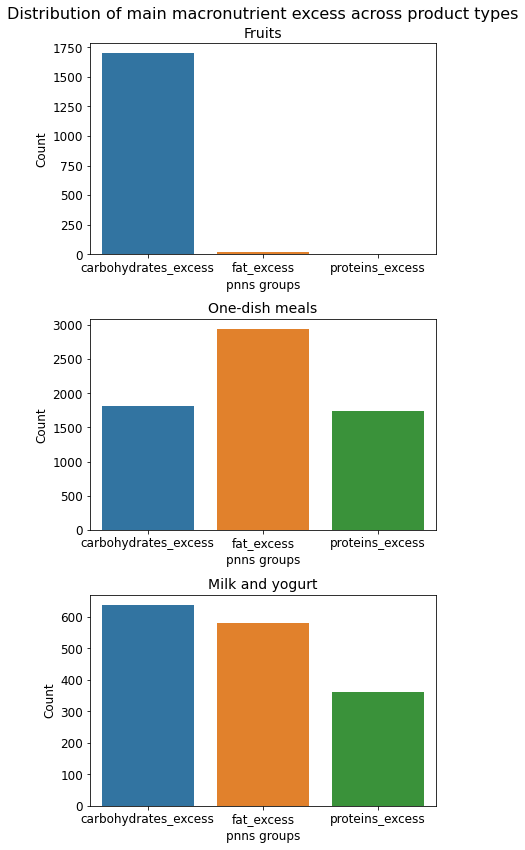

In [392]:
fs = 12
fig, axs = plt.subplots(nrows=X.pnns_groups_2.unique().size, figsize=(8, 12))
fig.suptitle("Distribution of main macronutrient excess across product types", fontsize=16)
for i, g in enumerate(X.pnns_groups_2.unique()):
    ax = axs[i]
    sns.countplot(x="max_excess", data=X[X.pnns_groups_2==g].sort_values(by="max_excess"), ax=ax)
    ax.set_xlabel("pnns groups", fontsize=fs)
    ax.set_ylabel("Count", fontsize=fs)
    ax.tick_params(axis='y', labelsize=fs)
    ax.tick_params(axis="x", labelsize=fs)
    ax.set_title(g, fontsize=14)
plt.tight_layout()
plt.gcf().subplots_adjust(left=0.2, right=0.8)
plt.savefig("./graphes/excess_foodgroups.png", dpi=300)
plt.show()

On a donc les associations suivantes:
- Les one-dish meals, les excès sont principalement des excès en lipides, puis en protéines et enfin en glucides
- Pour les fruits, les excès sont essentiellement des excès en glucides (les fruits sont des produits non gras, et ne contiennent pas ou peu de protéines)
- Enfin pour les milk and yogurt on a en premier lieu des excès en glucides (surement à cause des desserts sucrés), puis viennent les lipides et enfin les protéines.

# Conclusion

Le principe de fonctionnement repose essentiellement sur l'equiscore, qui permet de calculer l'écart d'une composition d'un produit à la composition idéale. Pour que l'application puisse fonctionner, il faut pouvoir "équilibrer" les apports d'un plat, avec les apports d'un autre plat. Or nous avons vu que les One-dish meals, les Fruits et les Milk and yogurt sont chacuns "spécialisés" dans un ou plusieurs macro-nutriment:
- les lipides et protéines en ce qui concerne les One-dish meals
- les glucides en ce qui concerne les fruits
- les glucides et les lipides en ce qui concerne les Milk and yogurt

Pour aller plus loin, on pourrait par exemple selectionner aléatoirement un one-dish meal, et à partir de sa composition décider si il faut lui adjoindre un fruit (carence en glucides) ou un yaourt (carence en lipides et/ou protéines) pour retrouver une meilleure composition. Il s'agira ensuite de calculer le nouvel equiscore et vérifier qu'il est bien inférieur au score initial. Enfin répéter cette opération un grand nombre de fois et vérifier à l'aide d'un test statistique approprié qu'on obtient obtient en moyenne de meilleurs equiscores avec les combinaisons proposées par l'app que sans l'app.

# -----------------------------------------------------------------

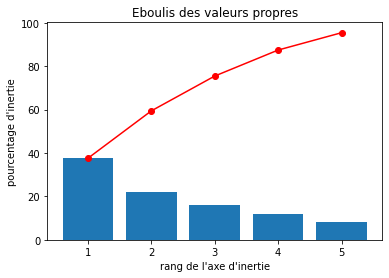

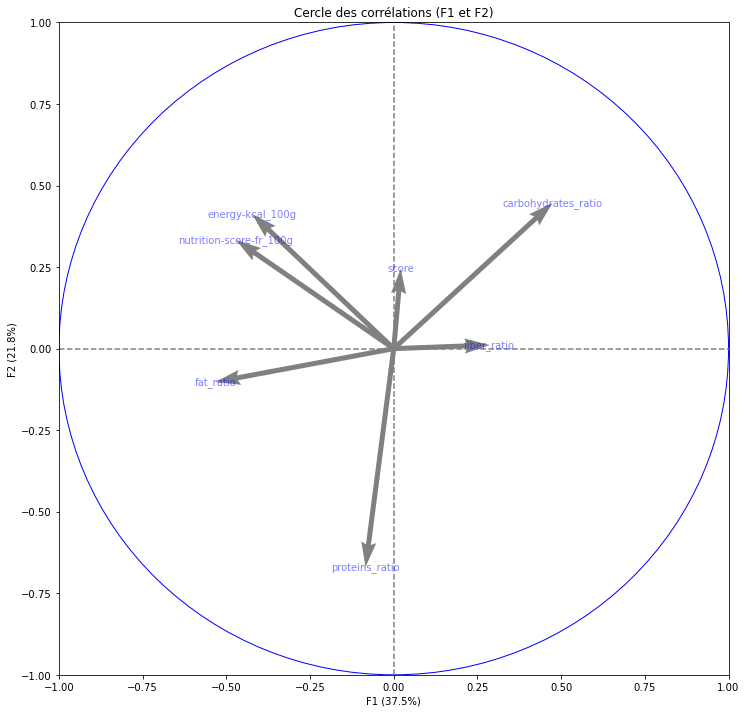

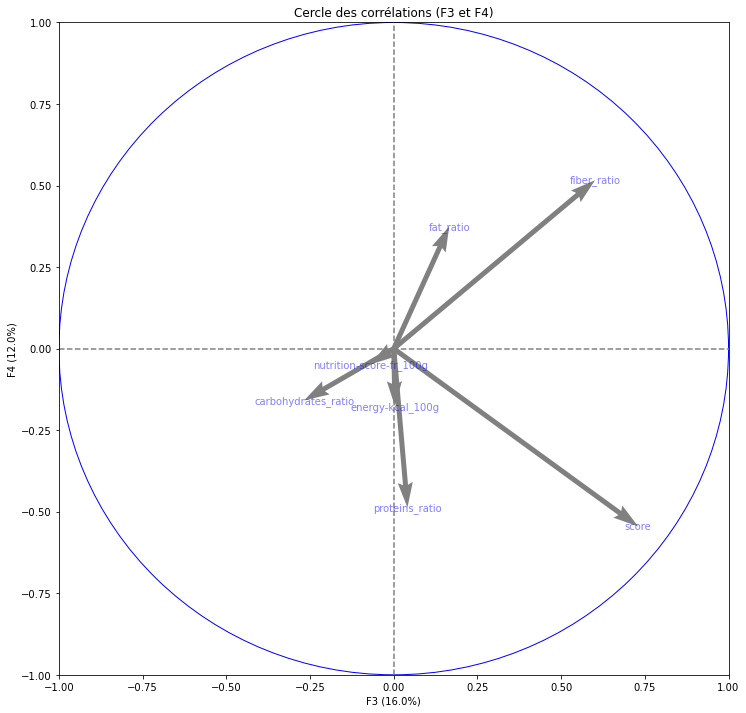

In [26]:
from sklearn import decomposition
from sklearn import preprocessing
from functions import *

# On ne récupère que les lignes pour lesquelles nutrition-score-fr_100g est renseignée.
y = X.loc[X["nutrition-score-fr_100g"].notna()]
y.index = pd.Index(range(0, y.shape[0]))

# On ne garde que les colonnes à prendre en compte dans l'ACP (c'est-à-dire les colonnes de valeurs numériques)
df_acp = y[["energy-kcal_100g", "nutrition-score-fr_100g",
            "fat_ratio","carbohydrates_ratio","proteins_ratio", "score", "fiber_ratio"]].dropna(subset=["score"])

features = df_acp.columns
index = y.index

# choix du nombre de composantes à calculer
n_comp = 5

# Centrage et RéductionS
std_scale = preprocessing.StandardScaler().fit(df_acp)
X_scaled = std_scale.transform(df_acp)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1), (2, 3)], labels = np.array(features))

In [27]:
print_acp_analysis(df_acp, pca)


F1 donné par :

carbohydrates_ratio 0.47
fiber_ratio 0.29
score 0.02
proteins_ratio -0.08
energy-kcal_100g -0.42
nutrition-score-fr_100g -0.47
fat_ratio -0.53

F2 donné par:

carbohydrates_ratio 0.45
energy-kcal_100g 0.41
nutrition-score-fr_100g 0.33
score 0.25
fiber_ratio 0.01
fat_ratio -0.10
proteins_ratio -0.67

F3 donné par:

score 0.73
fiber_ratio 0.60
fat_ratio 0.17
proteins_ratio 0.04
energy-kcal_100g 0.00
nutrition-score-fr_100g -0.07
carbohydrates_ratio -0.27


Le premier axe d'inertie est principalement corrélé à "fat_ratio", "fiber_ratio", et principalement anticorrélé à carbohydrates_ratio. Il est corrélé dans une moindre mesure avec "score" (c'est-à-dire l'equiscore), "nutrition-score-fr_100g" puis "energy-kcal_100g".

Le deuxième axe est principalement corrélé à "proteins_ratio". Il est ensuite anticorrélé à "energy-kcal_100g", "carbohydrates_ratio" et "nutrition-score-fr_100g".

Le troisième axe est principalement corrélé à proteins_ratio, energy-kcal_100g, nutrition-score-fr_100g, et principalement anticorrélé à score

Le dernier axe est lui essentiellement corrélé à "score", corrélé également à proteins_ratio, et anticorrélé à fat_ratio et fiber_ratio.

On a donc 4 groupes de variables, correspondant à chacun des quatre axes. Par rapport à notre problématique initiale, on peut donc considérer qu'on a trois variables synthétiques: 
- la première va nous permettre de sélectionner les produits directement selon leur contenu en fibres, lipides et glucides.
- la deuxième va nous permettre de sélectionner les produits selon leur contenu en protéines. Affichons quelques exemples concrets.

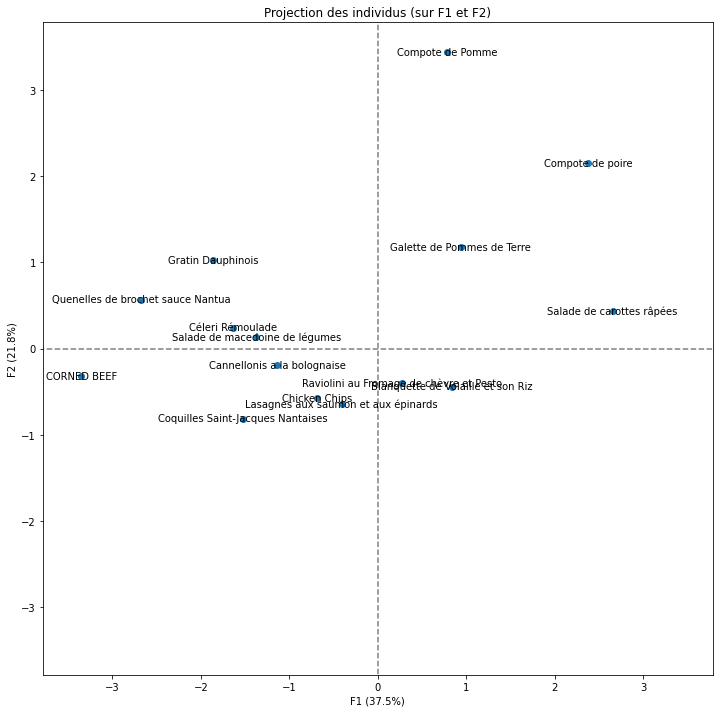

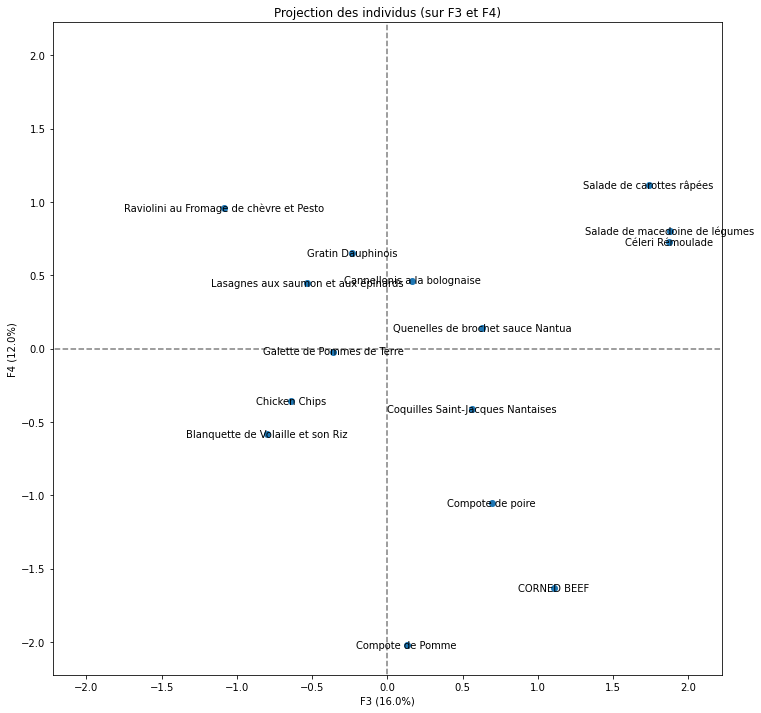

In [28]:
# Projections des individus
id = index[:15]
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected[id], n_comp, pca, [(0,1),(2,3)], labels=y.iloc[id]["product_name"].to_numpy())
#X_projected[:, "score_group"] = score

In [29]:
print_product_analysis(y, X_projected, 0, 7, axe=1)

Pour deux produits de F1 différents:

Premier produit: Salade de carottes râpées (Valeur élevée):
energy-kcal_100g                  32
fat_ratio                  0.0835913
carbohydrates_ratio         0.656347
proteins_ratio              0.111455
fiber_ratio                 0.148607
score                       0.659907
nutrition-score-fr_100g            1
Name: 0, dtype: object
----------------------------------------
Deuxième produit: Céleri Rémoulade (Valeur basse):
energy-kcal_100g                 145
fat_ratio                   0.810249
carbohydrates_ratio        0.0969529
proteins_ratio             0.0554017
fiber_ratio                0.0373961
score                       0.945291
nutrition-score-fr_100g            3
Name: 7, dtype: object


**On retrouve donc le fait que le produit de F1 plus élevé (à F2 identique) est plus énergétique et gras, contient plus de fibres et contient moins de glucides (pour 100g)**

In [30]:
print_product_analysis(y, X_projected, 4, 6, axe=2)

Pour deux produits de F2 différents:

Premier produit: Blanquette de Volaille et son Riz (Valeur basse):
energy-kcal_100g                  109
fat_ratio                    0.181402
carbohydrates_ratio          0.560696
proteins_ratio               0.249198
fiber_ratio                0.00870362
score                        0.369789
nutrition-score-fr_100g             0
Name: 4, dtype: object
----------------------------------------
Deuxième produit: Compote de Pomme (Valeur élevée):
energy-kcal_100g                  377
fat_ratio                   0.0116701
carbohydrates_ratio           0.96473
proteins_ratio              0.0155602
fiber_ratio                0.00803942
score                         1.02946
nutrition-score-fr_100g             1
Name: 6, dtype: object


**On retrouve donc le fait que le produit de F2 plus élevé (à F1 identique) est moins énergétique, contient moins de glucides et plus de protéines**

In [31]:
print_product_analysis(y, X_projected, 9, 13, axe=3)

Pour deux produits de F3 différents:

Premier produit: Chicken Chips (Valeur basse):
energy-kcal_100g                 198
fat_ratio                   0.324649
carbohydrates_ratio         0.352705
proteins_ratio              0.306613
fiber_ratio                0.0160321
score                       0.263226
nutrition-score-fr_100g            4
Name: 9, dtype: object
----------------------------------------
Deuxième produit: Cannellonis a la bolognaise (Valeur élevée):
energy-kcal_100g                 169
fat_ratio                   0.579286
carbohydrates_ratio         0.241077
proteins_ratio              0.159157
fiber_ratio                0.0204798
score                       0.458572
nutrition-score-fr_100g            3
Name: 13, dtype: object


**On retrouve le fait que le produit de F3 plus élevé (à F4 identique) contient plus de protéines, est plus énergétique, possède un nutriscore plus élevé et un score moins élevé.**

Ces axes peuvent être utiles si par exemple, on souhaite équilibrer un premier produit par un produit possédant un ensemble de caractéristiques:
- en se déplaçant sur F1 à F2 égal, on pourra sélectionner des produits dont le contenu en protéines est à peu près similaire, mais dont les contenus en lipides, glucides et fibres sont différents.
- de même, en se déplaçant sur 

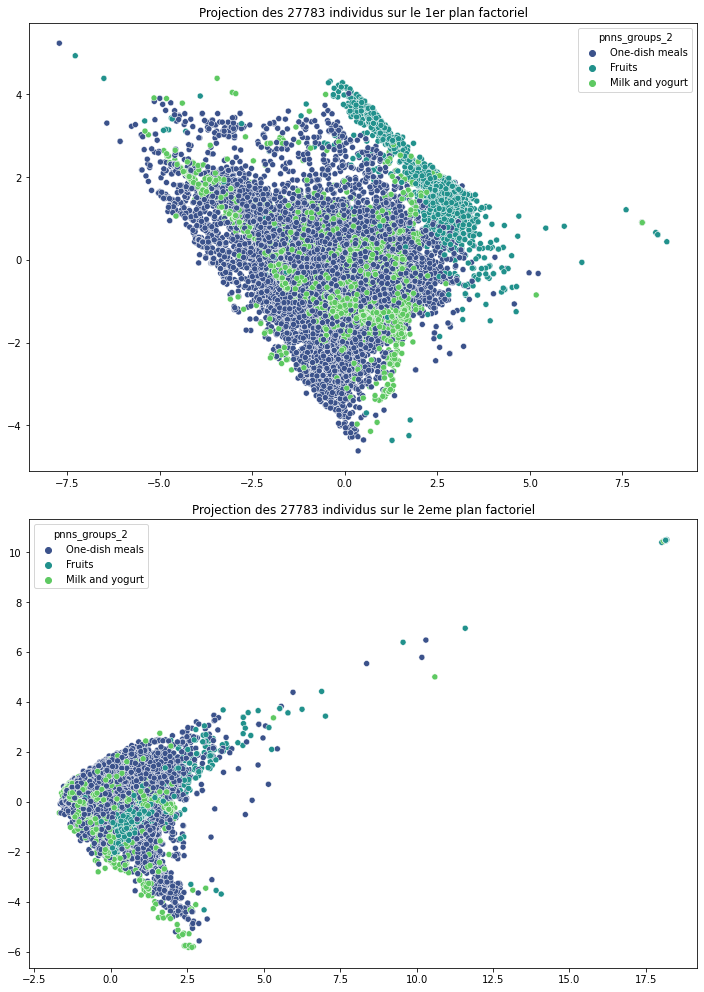

In [32]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 14))
# Affichage du clustering par projection des individus sur le premier plan factoriel
#pca = decomposition.PCA(n_components=4).fit(df_acp)
#X_projected = pca.transform(df_acp)
sns.scatterplot(x=X_projected[:, 0], 
                y=X_projected[:, 1], 
                data=X_projected, 
                hue=y.dropna(subset=["score"])["pnns_groups_2"], 
                palette="viridis",
                ax=ax1)
ax1.set_title("Projection des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))

sns.scatterplot(x=X_projected[:, 2], 
                y=X_projected[:, 3], 
                data=X_projected,
                hue=y.dropna(subset=["score"])["pnns_groups_2"], 
                palette="viridis", 
                ax=ax2)
ax2.set_title("Projection des {} individus sur le 2eme plan factoriel".format(X_projected.shape[0]))

plt.tight_layout(pad=1.5)
plt.show()

In [33]:
def print_product_analysis(df, X_proj, id1, id2, axe=1):
    
    prod1 = dict()
    prod2 = dict()
    
    # Récupération du nom des produits à partir des index
    prod1["name"] = df.iloc[id1]["product_name"]
    prod2["name"] = df.iloc[id2]["product_name"]
    
    # analyse selon l'axe choisi
    if axe==1:
        print("Pour deux produits de F1 différents:\n")
    elif axe==2:
        print("Pour deux produits de F2 différents:\n")
    elif axe==3:
        print("Pour deux produits de F3 différents:\n")
    
    # Variables conservées pour l'analyse
    var = ["energy-kcal_100g",
           "fat_ratio", 
           "carbohydrates_ratio",
           "proteins_ratio",
           "fiber_ratio",
           "score",
           "nutrition-score-fr_100g"]
    
    
    # Valeur basse vs. valeur élevée pour l'axe
    prod1["val"] = X_proj[id1, axe-1]
    prod2["val"] = X_proj[id2, axe-1]
    text1 = "Valeur basse"
    text2 = "Valeur élevée"
    
    if prod1["val"] < prod2["val"]:
        prod1["text"] = text1
        prod2["text"] = text2
    else:
        prod1["text"] = text2
        prod2["text"] = text1
    
    # Affichage de l'analyse
    print(f"Premier produit: {prod1['name']} ({prod1['text']}):")
    print(df.iloc[id1][var])
    print("-"*40)
    print(f"Deuxième produit: {prod2['name']} ({prod2['text']}):")
    print(df.iloc[id2][var])

In [34]:
def print_acp_analysis(df, pca):
    print("\nF1 donné par :\n")
    for v,c in sorted(list(zip(df.columns.to_numpy(), pca.components_[0])), key=lambda x: x[1], reverse=True):
        print("{} {:.2f}".format(v,c))
    print("\nF2 donné par:\n")
    for v,c in sorted(list(zip(df.columns.to_numpy(), pca.components_[1])), key=lambda x: x[1], reverse=True):
        print("{} {:.2f}".format(v,c))
    print("\nF3 donné par:\n")
    for v,c in sorted(list(zip(df.columns.to_numpy(), pca.components_[2])), key=lambda x: x[1], reverse=True):
        print("{} {:.2f}".format(v,c))
    print("\nF4 donné par:\n")
    for v,c in sorted(list(zip(df.columns.to_numpy(), pca.components_[3])), key=lambda x: x[1], reverse=True):
        print("{} {:.2f}".format(v,c))

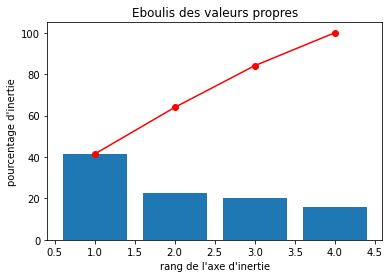

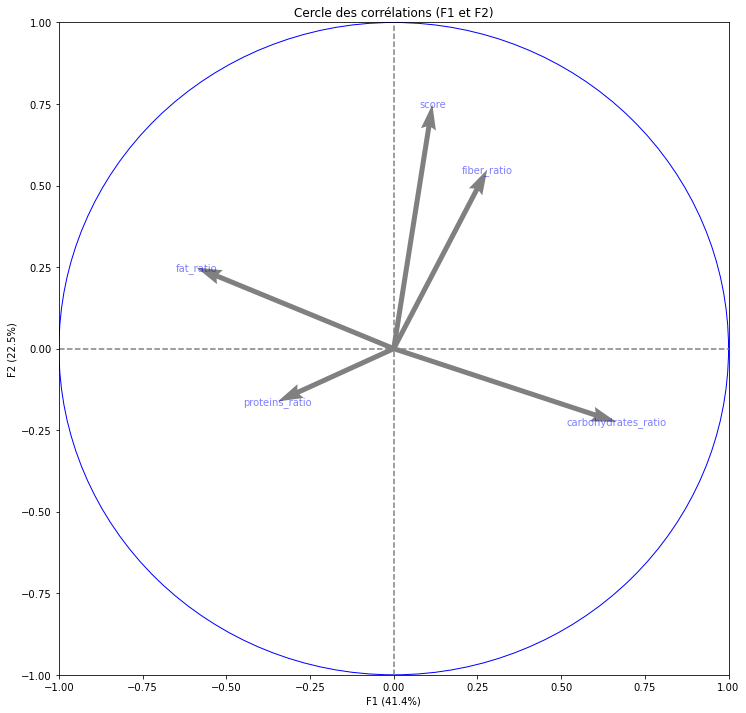

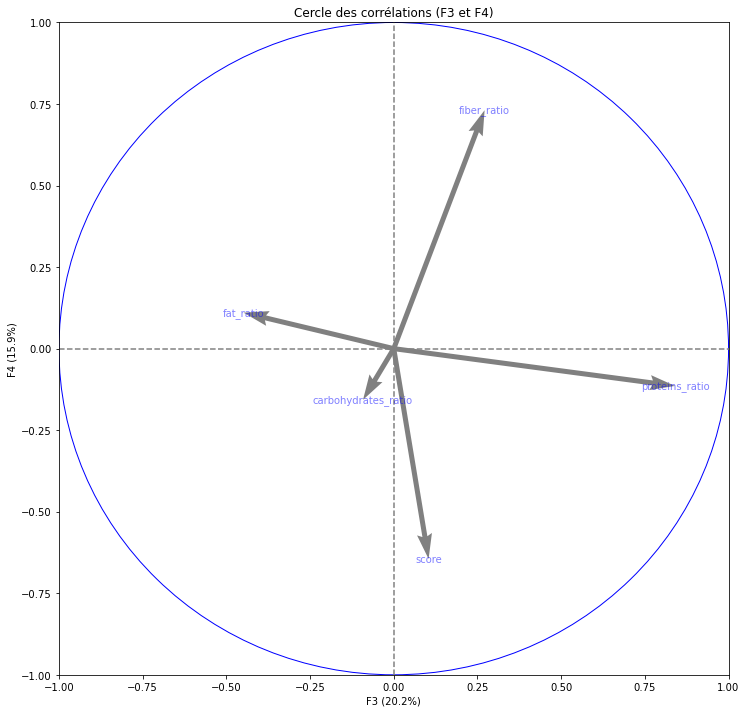

In [35]:
from sklearn import decomposition
from sklearn import preprocessing
from functions import *

# On ne récupère que les lignes pour lesquelles nutrition-score-fr_100g est renseignée.
y = X.loc[X["nutrition-score-fr_100g"].notna()]
y.index = pd.Index(range(0, y.shape[0]))

# On ne garde que les colonnes à prendre en compte dans l'ACP (c'est-à-dire les colonnes de valeurs numériques)
df_acp = y[["fat_ratio","carbohydrates_ratio","proteins_ratio", "score", "fiber_ratio"]].dropna(subset=["score"])

features = df_acp.columns
index = y.index

# choix du nombre de composantes à calculer
n_comp = 4

# Centrage et RéductionS
std_scale = preprocessing.StandardScaler().fit(df_acp)
X_scaled = std_scale.transform(df_acp)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1), (2, 3)], labels = np.array(features))

In [36]:
print_acp_analysis(df_acp, pca)


F1 donné par :

carbohydrates_ratio 0.66
fiber_ratio 0.28
score 0.12
proteins_ratio -0.35
fat_ratio -0.59

F2 donné par:

score 0.75
fiber_ratio 0.55
fat_ratio 0.25
proteins_ratio -0.16
carbohydrates_ratio -0.22

F3 donné par:

proteins_ratio 0.84
fiber_ratio 0.27
score 0.10
carbohydrates_ratio -0.09
fat_ratio -0.45

F4 donné par:

fiber_ratio 0.73
fat_ratio 0.11
proteins_ratio -0.11
carbohydrates_ratio -0.16
score -0.64


Table de contingence:


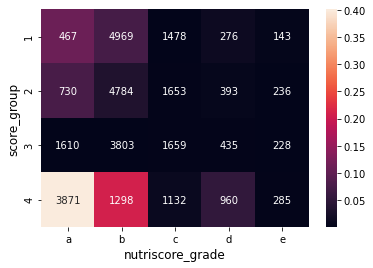

Table d'indépendance, à titre de comparaison:


nutriscore_grade,a,b,c,d,e,Total
score_group,,,,,,
1,1610,3581,1428,497,215,7333
2,1711,3808,1518,529,228,7796
3,1698,3778,1506,524,226,7735
4,1657,3685,1469,512,221,7546
Total,6678,14854,5922,2064,892,30410


In [379]:
# Création du tableau de contingence
x = "score_group"
y = "nutriscore_grade"

cont = X[[x,y]].pivot_table(index=x,columns=y,aggfunc=len,margins=True,margins_name="Total")
tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = cont.loc["Total", "Total"]
indep = tx.dot(ty) / n

c = cont.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
plt.ylabel("Groupe d'equiscore", fontsize=12)
plt.xlabel("Classe de nutriscore", fontsize=12)
print("Table de contingence:")
sns.heatmap(table.iloc[:-1,:-1], annot=c.iloc[:-1,:-1], fmt=".0f")
plt.show()
print("Table d'indépendance, à titre de comparaison:")
indep.astype('int')

Ce résultat est intéressant: il nous dit, contrairement à nos attentes, qu'il existe bien une prévalence des groupes de nutriscore "a", et "d" dans le groupe d'équiscore "d". Cependant, il n'y a pas de corrélation "simple" entre les deux scores: un groupe de plus faible equiscore n'est pas en général associé à un groupe de meilleur nutriscore.

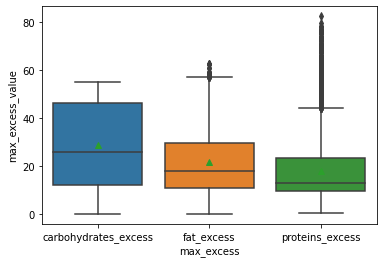

In [401]:
sns.boxplot(x="max_excess", 
            y="max_excess_value", 
            data=X.sort_values(by="max_excess"), 
            showmeans=True)
plt.show()

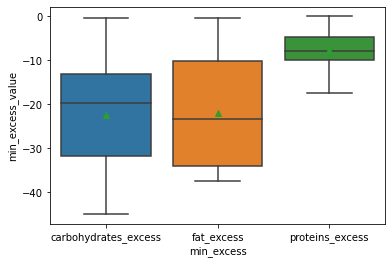

In [402]:
sns.boxplot(x="min_excess", 
            y="min_excess_value", 
            data=X.sort_values(by="min_excess"), 
            showmeans=True)
plt.show()